## 🔬 Control Dataset Overview

This notebook analyzes spontaneous calcium activity in BxPC3 pancreatic cancer cells imaged under identical control conditions across six image sequences.

**Experimental context:**
- Cell line: BxPC3 (pancreatic ductal adenocarcinoma)
- Imaging: DIV2, seeded at 1.2 million cells per well (high confluence)
- Ca²⁺ dye: Fluo-4 AM (standard loading protocol)
- Nuclei: Hoechst 33342 (10 µg/mL)
- Acquisition: FITC, 1 Hz, 30 ms exposure for 30 minutes

This is the **first run** of spontaneous activity under control conditions. The goal is to assess the **reproducibility** and **biological variability** of peak-, cell-, and event-level metrics across replicates.

## ⚙️ Setup & Utilities

Standard scientific libraries (Pandas, NumPy, Seaborn) and custom plotting utilities are loaded. These functions enable streamlined metric visualization and layout control across multiple datasets.

In [1]:
# Libraries
import seaborn as sns
import numpy as np
from pathlib import Path
import sys

# Add /Source to sys.path if not already present
project_root = Path.cwd().parent
source_path = project_root / "src"

if source_path.exists() and str(source_path) not in sys.path:
    sys.path.insert(0, str(source_path))

# Utility functions
from calcium_activity_characterization.analysis.visualizers import plot_metric_by_dataset, plot_category_distribution_by_dataset, plot_raster_plots_by_dataset
from calcium_activity_characterization.analysis.loaders import load_and_merge_datasets

sns.set(style="whitegrid")

# Define paths to control datasets
control_paths = {
    "20250326 - IS1": "D:/Mateo/20250326/Output/IS1",
    "20250326 - IS3": "D:/Mateo/20250326/Output/IS3",
    "20250404 - IS1": "D:/Mateo/20250404/Output/IS1",
    "20250404 - IS3": "D:/Mateo/20250404/Output/IS3",
    "20250409 - IS09": "D:/Mateo/20250409/Output/IS09",
    "20250409 - IS11": "D:/Mateo/20250409/Output/IS11",
}

# Load and merge datasets
peaks = load_and_merge_datasets(control_paths=control_paths, file_name="peaks.csv")
cells = load_and_merge_datasets(control_paths=control_paths, file_name="cells.csv")
events = load_and_merge_datasets(control_paths=control_paths, file_name="events.csv")

## 🧼 Preprocessing

Before visual comparison, we normalize event labels (e.g., missing `in_event` entries set to `'individual'`) and compute additional derived fields (`is_active`, `periodicity_score`) to ensure consistent comparisons across all datasets.

These steps are crucial for **ensuring fair metric aggregation** and enabling downstream comparative analysis.

In [2]:
peaks["in_event"] = peaks["in_event"].fillna("individual").str.lower()

if "is_active" not in cells.columns:
    cells["is_active"] = cells["num_peaks"].apply(lambda x: 1 if x > 0 else 0)

if "periodicity_score" not in cells.columns:
    cells["periodicity_score"] = np.nan

## 🖼️ Raster Plot Inspection

Raster plots provide a binary overview of calcium activity over time per cell.

*Remarks:* 
*TODO*

📌 Use these plots to **screen visually for anomalies or batch effects** before statistical analysis.

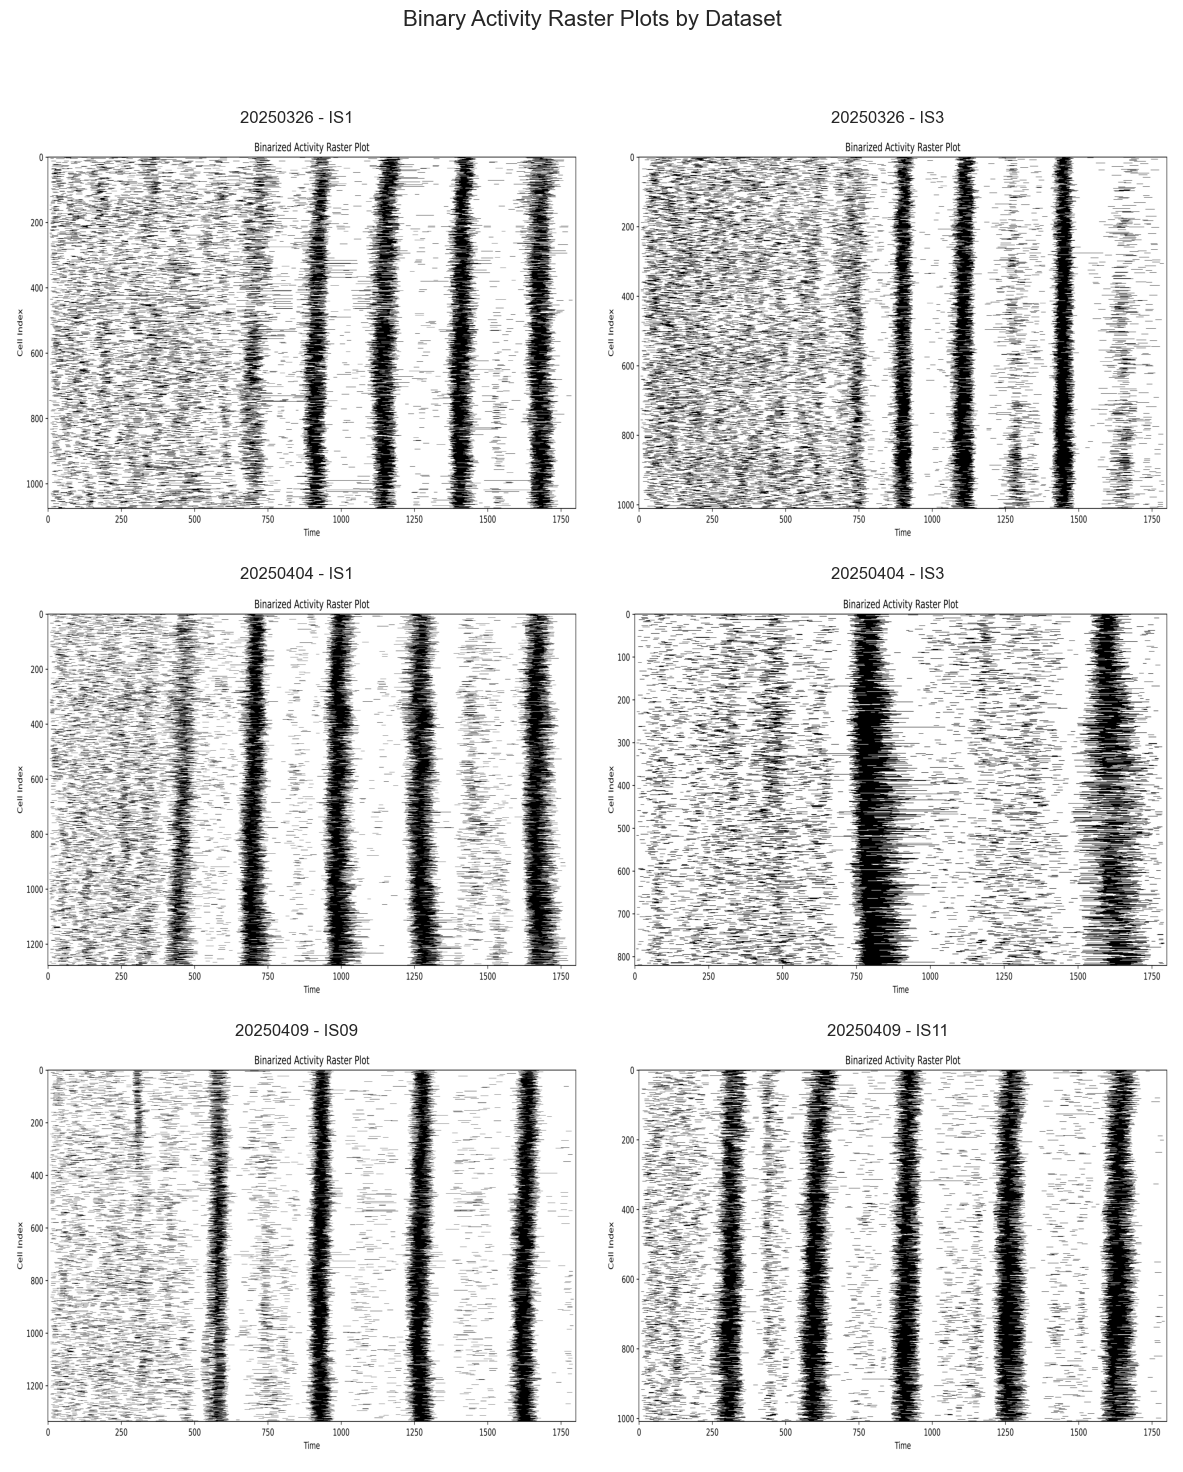

In [3]:
plot_raster_plots_by_dataset(
    dataset_paths=control_paths,
    title="Binary Activity Raster Plots by Dataset"
)

## 📊 Peak Type Distribution

Pie charts quantify the proportion of detected calcium peaks classified as:
- `individual`: isolated peaks
- `sequential`: propagating local events
- `global`: large-scale synchronized events

*Interpretation:*

*The distribution of peaks by event type (global, sequential, individual) across First Run control datasets is highly consistent.*

- *Approximately **30-40% global events** are consistently observed, except in image sequence `2025-04-04 IS3`, where fewer global events were detected.*

- *Sequential and individual peaks maintain stable proportions across datasets, indicating reproducible spontaneous calcium signaling activity under standard conditions.*

*First run image sequences demonstrate reproducible and robust peak-type distribution, validating their reliability as control data.*

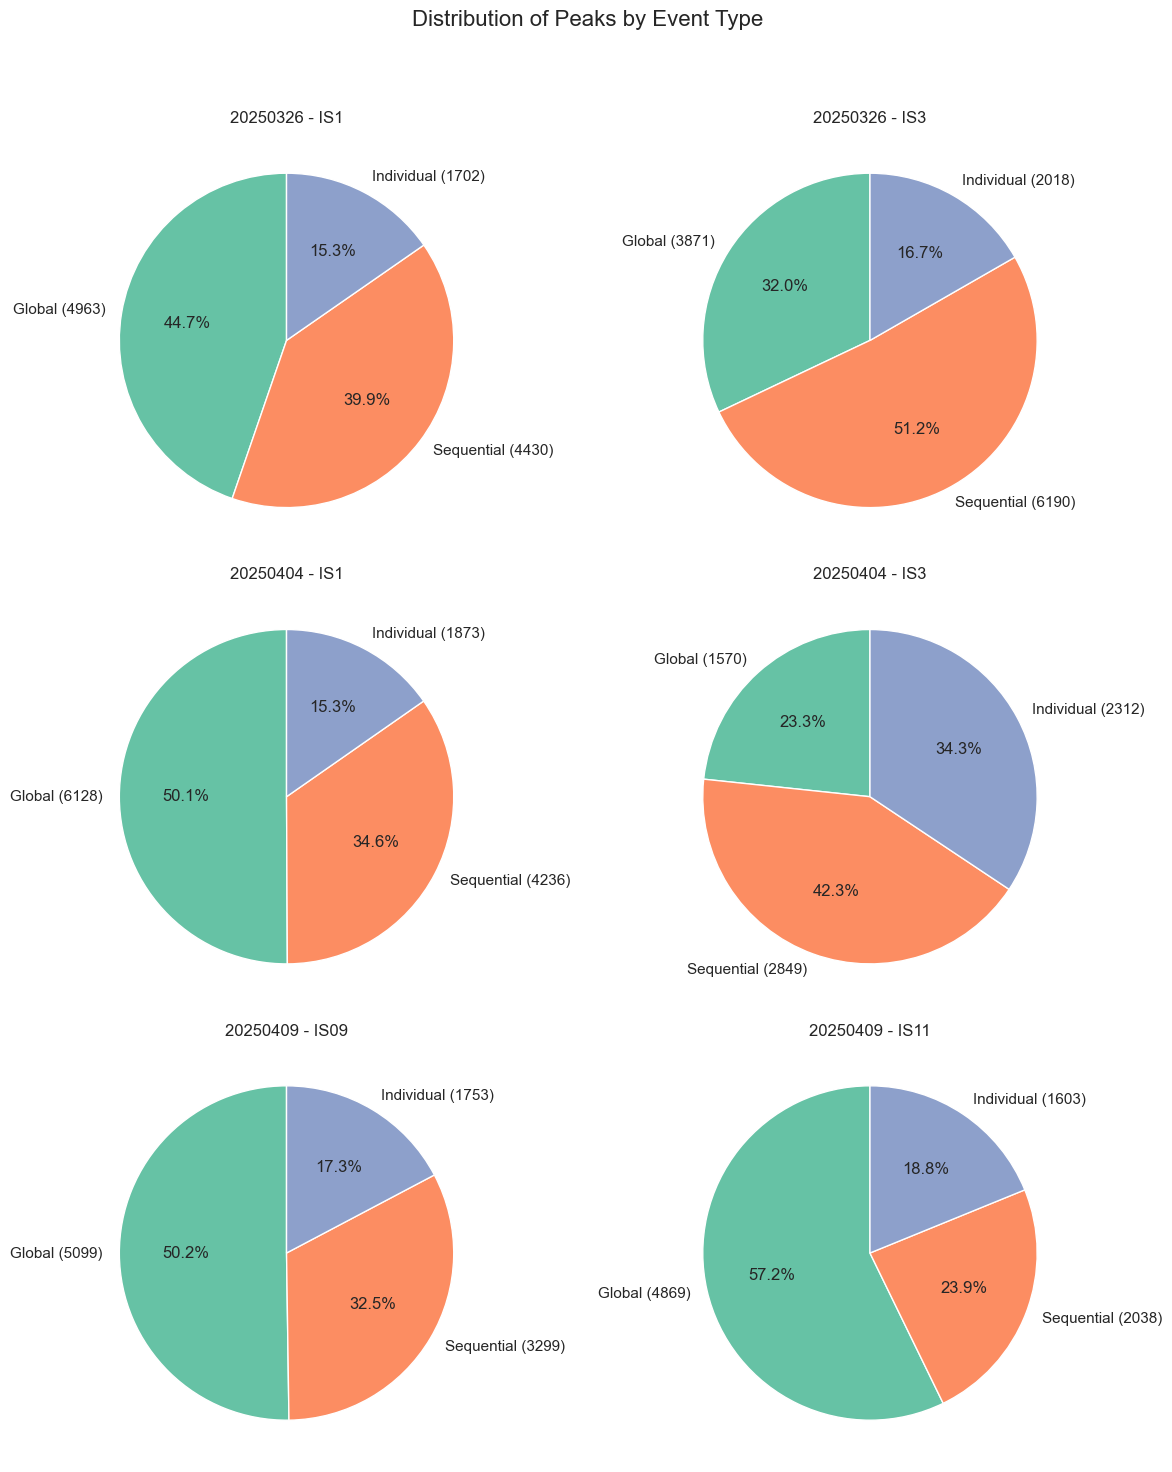

In [4]:
peak_type_colors = {
    "global": "#66c2a5",
    "sequential": "#fc8d62",
    "individual": "#8da0cb"
}

plot_category_distribution_by_dataset(
    df=peaks,
    column="in_event",
    category_order=["global", "sequential", "individual"],
    colors=peak_type_colors,
    title="Distribution of Peaks by Event Type"
)

## 📈 Peak Metrics per Event Type

Metrics like **duration**, **prominence**, and **symmetry** are visualized per event type.  

*Interpretation:*

- *Global peaks: Characteristically long durations (~50 frames).*

- *Sequential peaks: Duration means around **26–28 frames**; symmetry values around **0.9 ± 0.12**.*

- *Individual peaks: Duration around **26–27 frames**, also with symmetry ~0.9 ± 0.12.*

*Overall, the peak metrics in the First Run are stable, biologically plausible, and reproducible.*


#🔍 Peak Type: Global — 26500 peaks


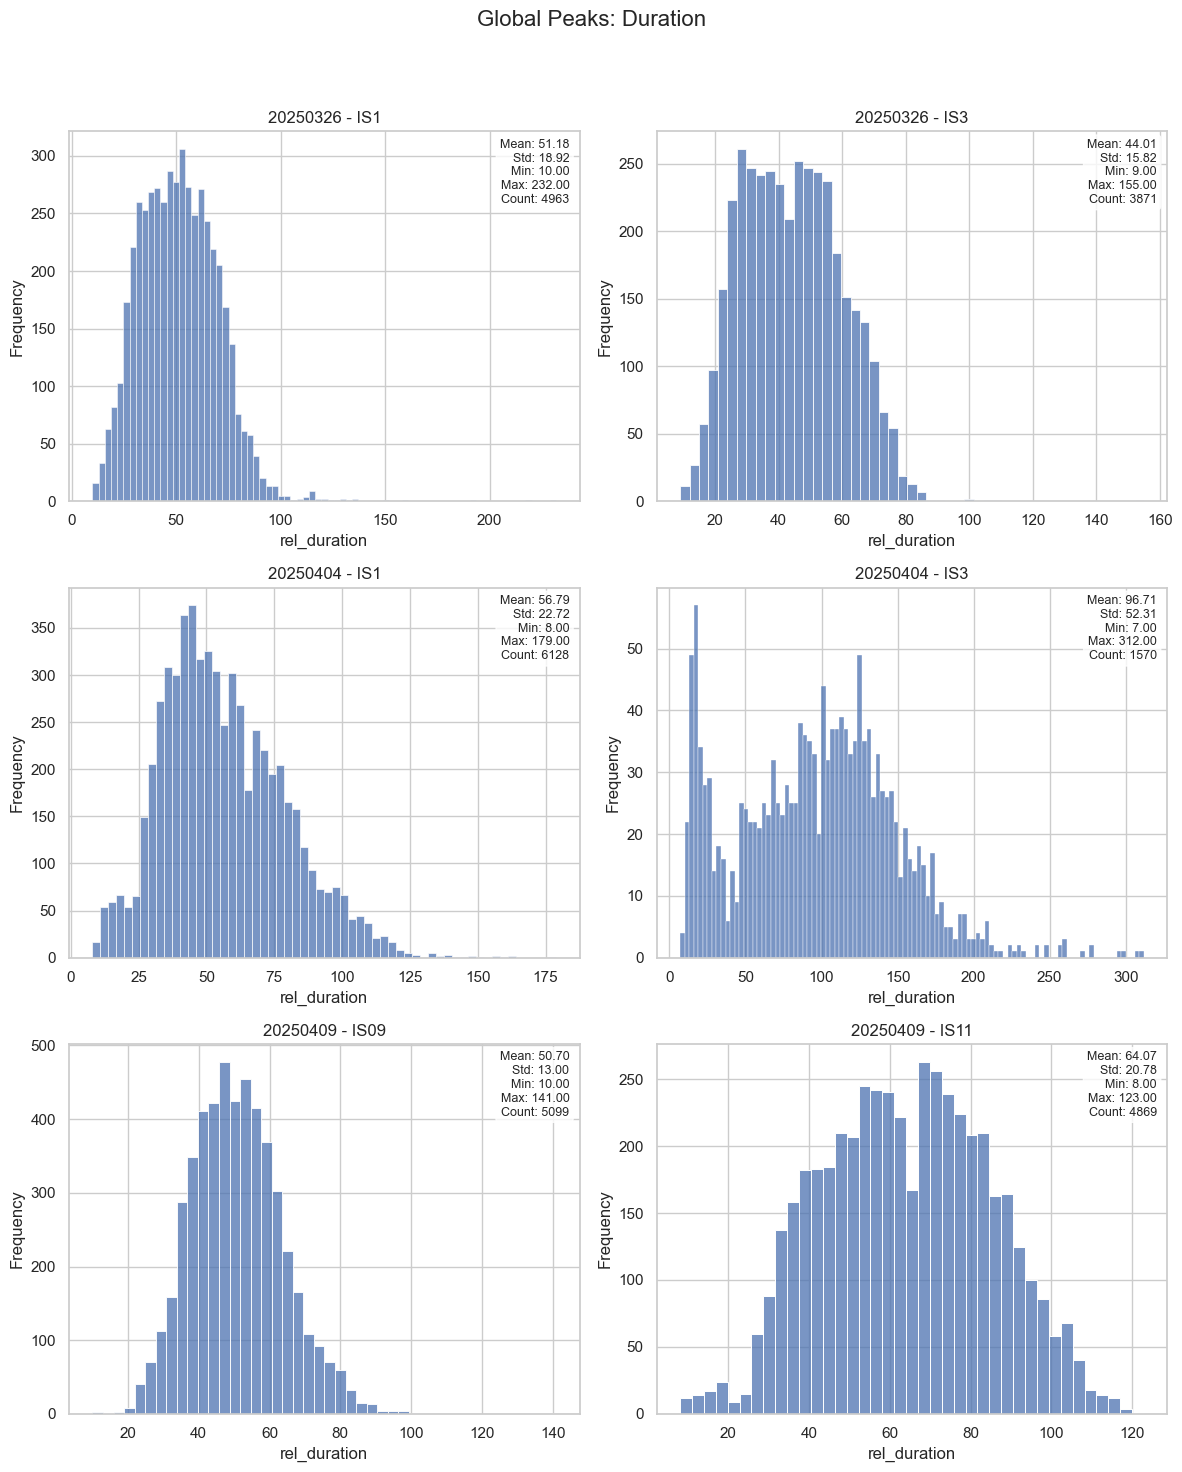

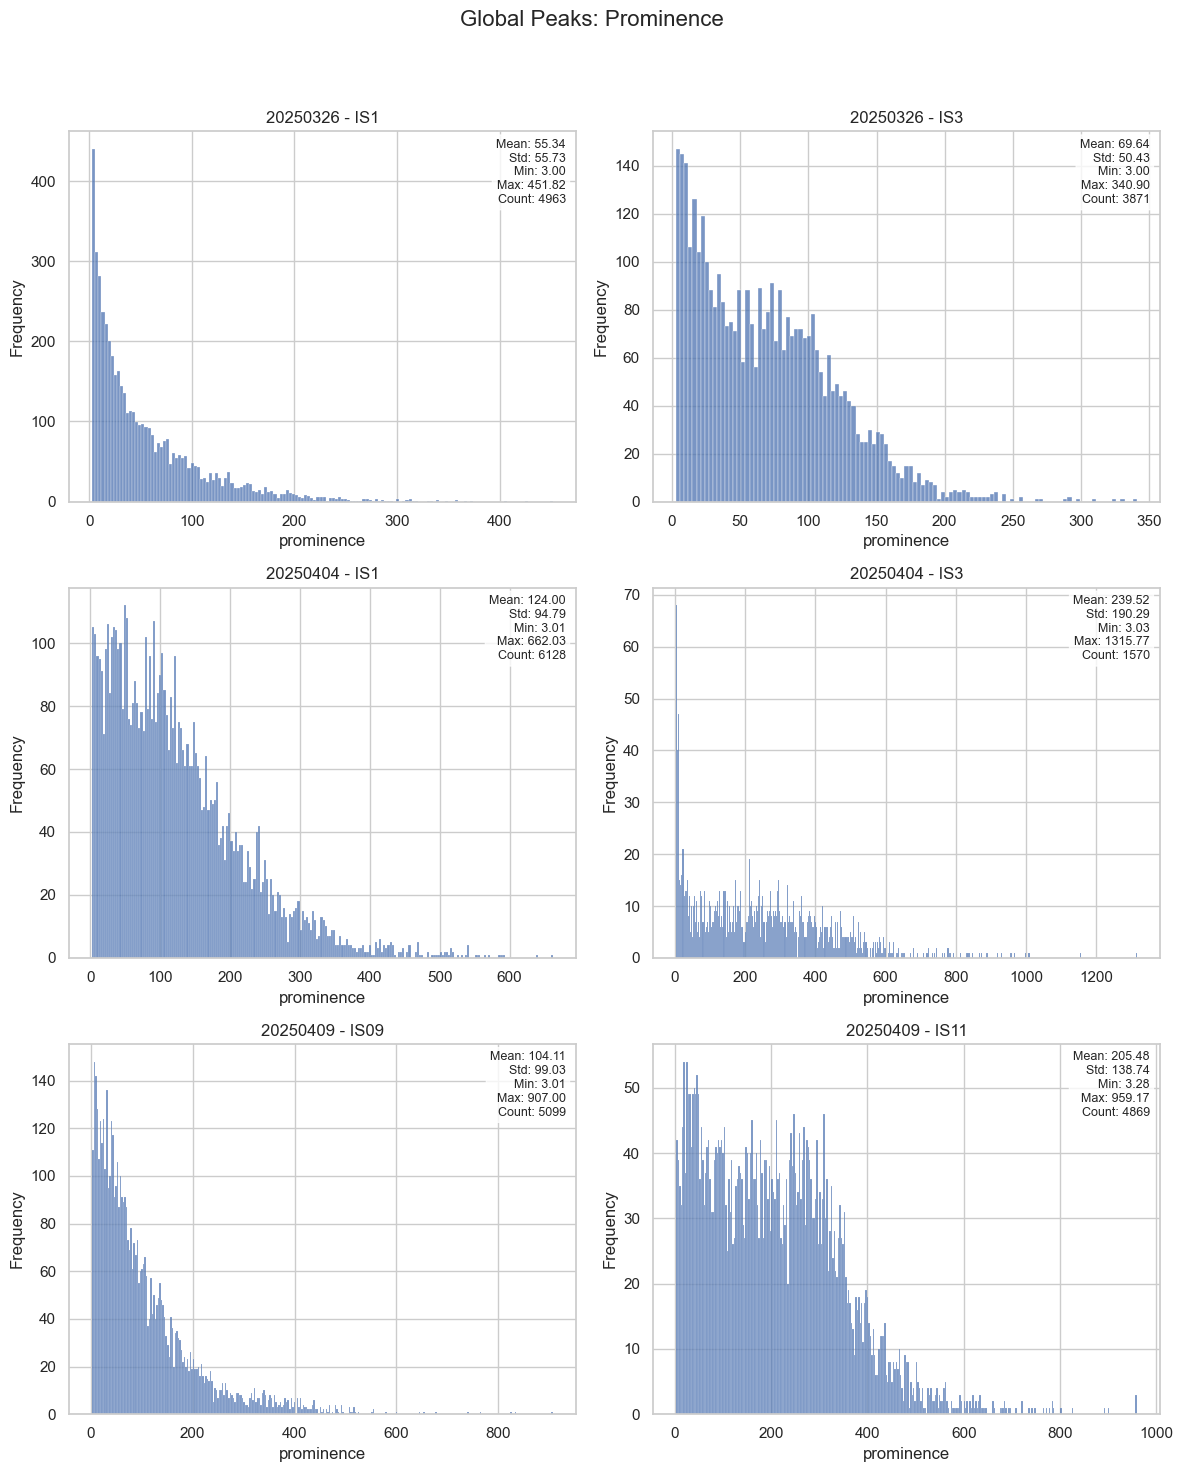

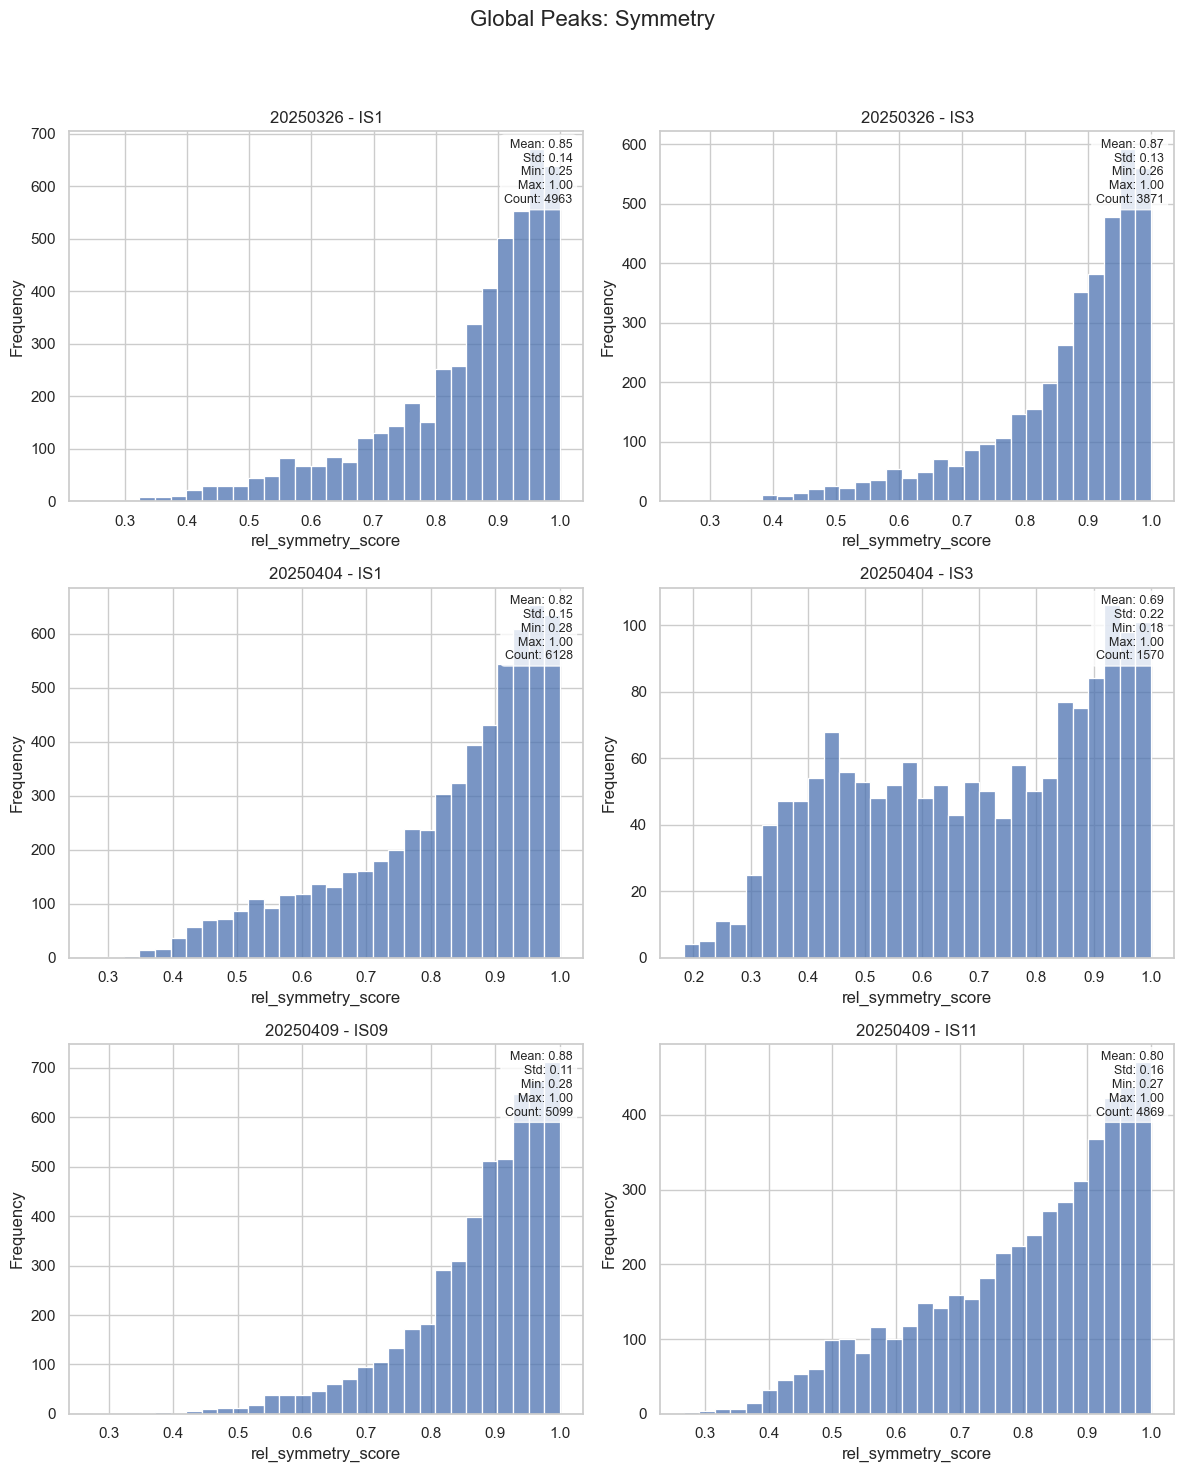


#🔍 Peak Type: Sequential — 23042 peaks


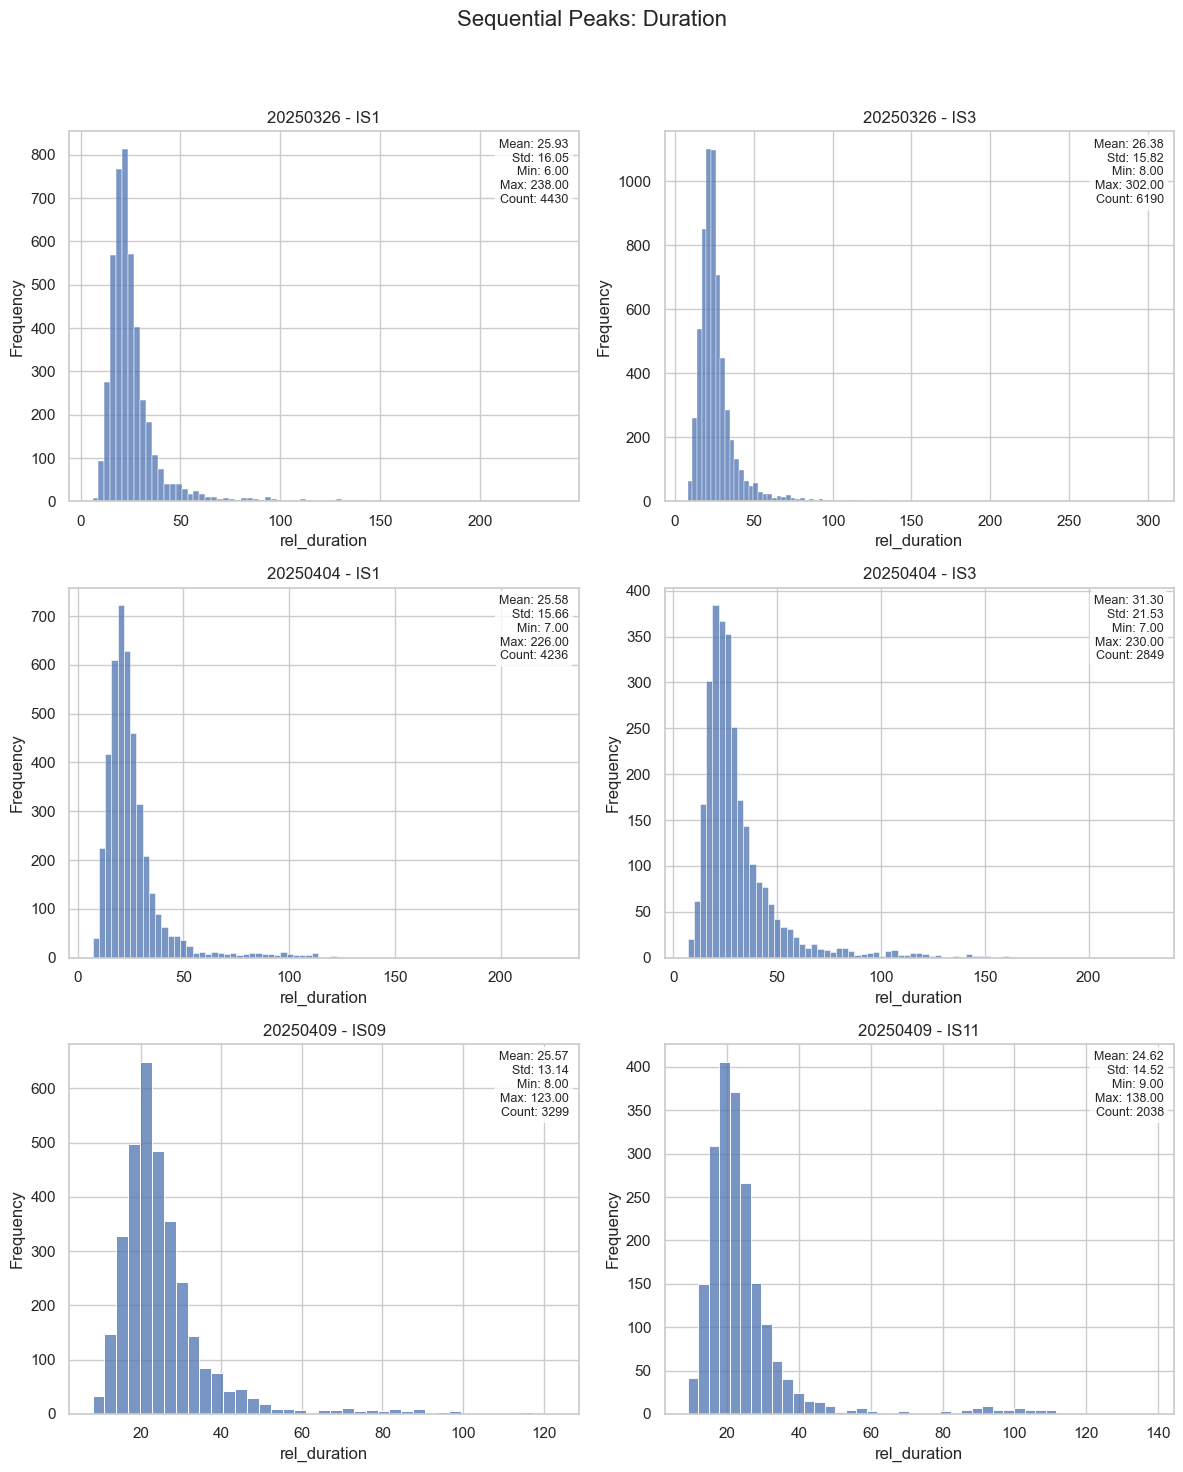

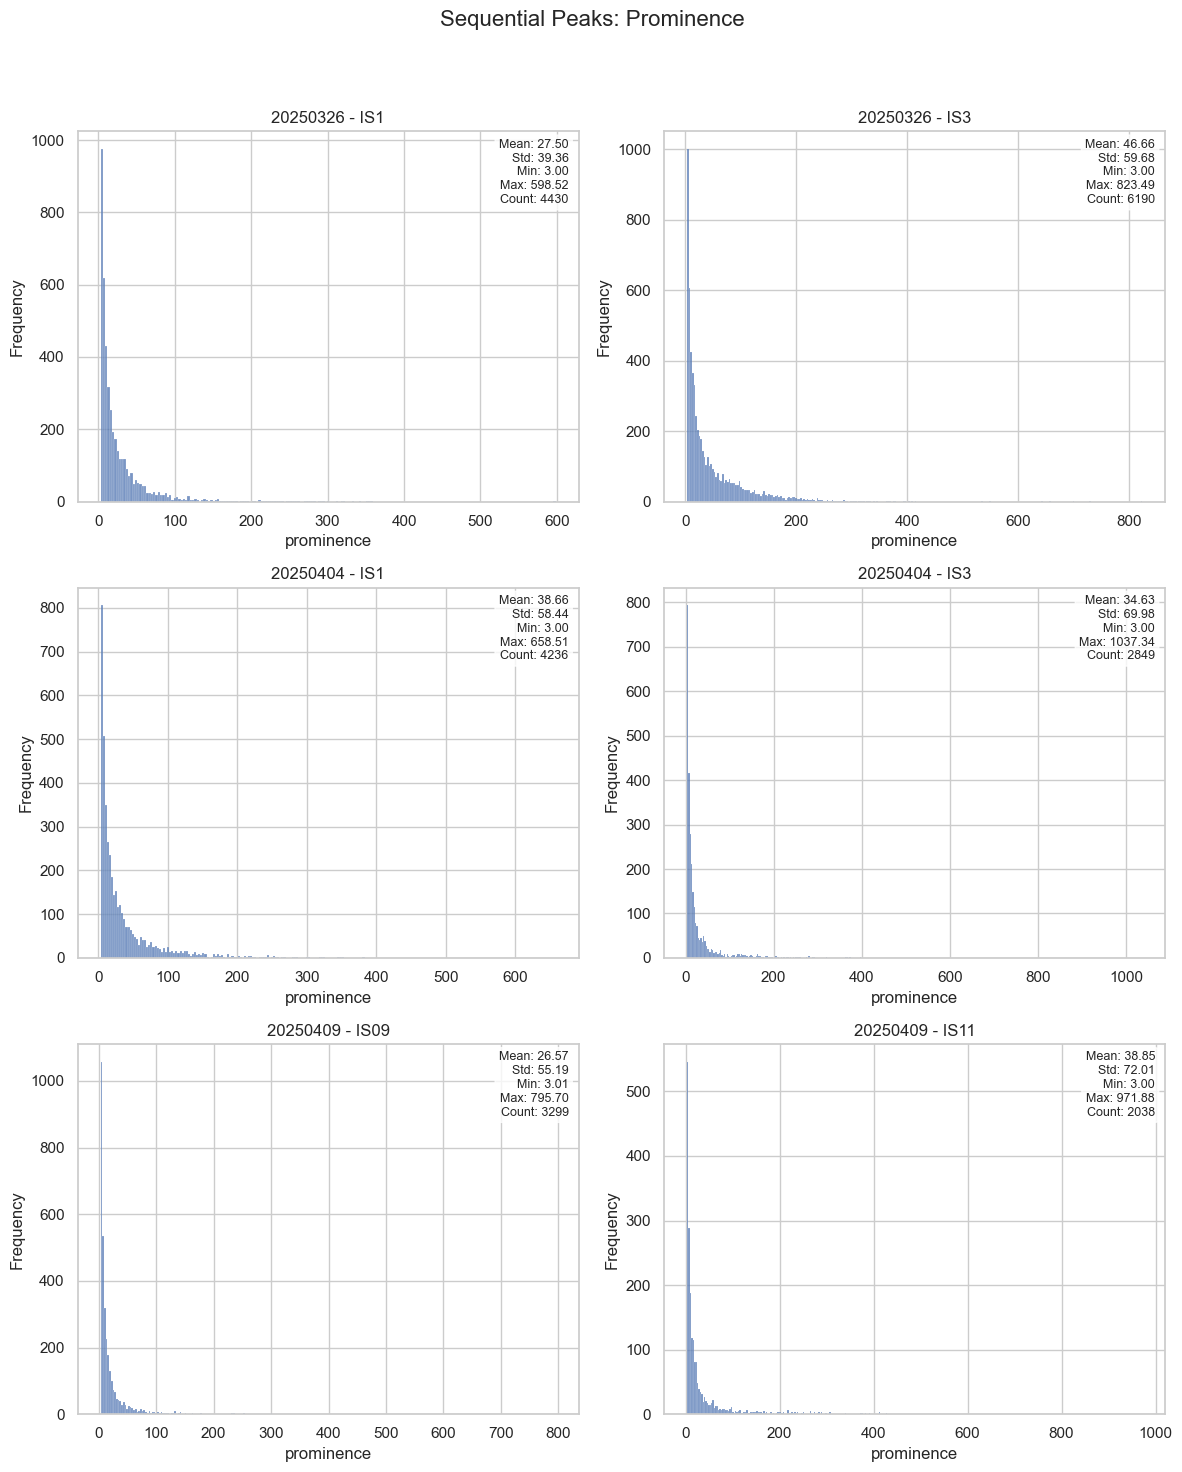

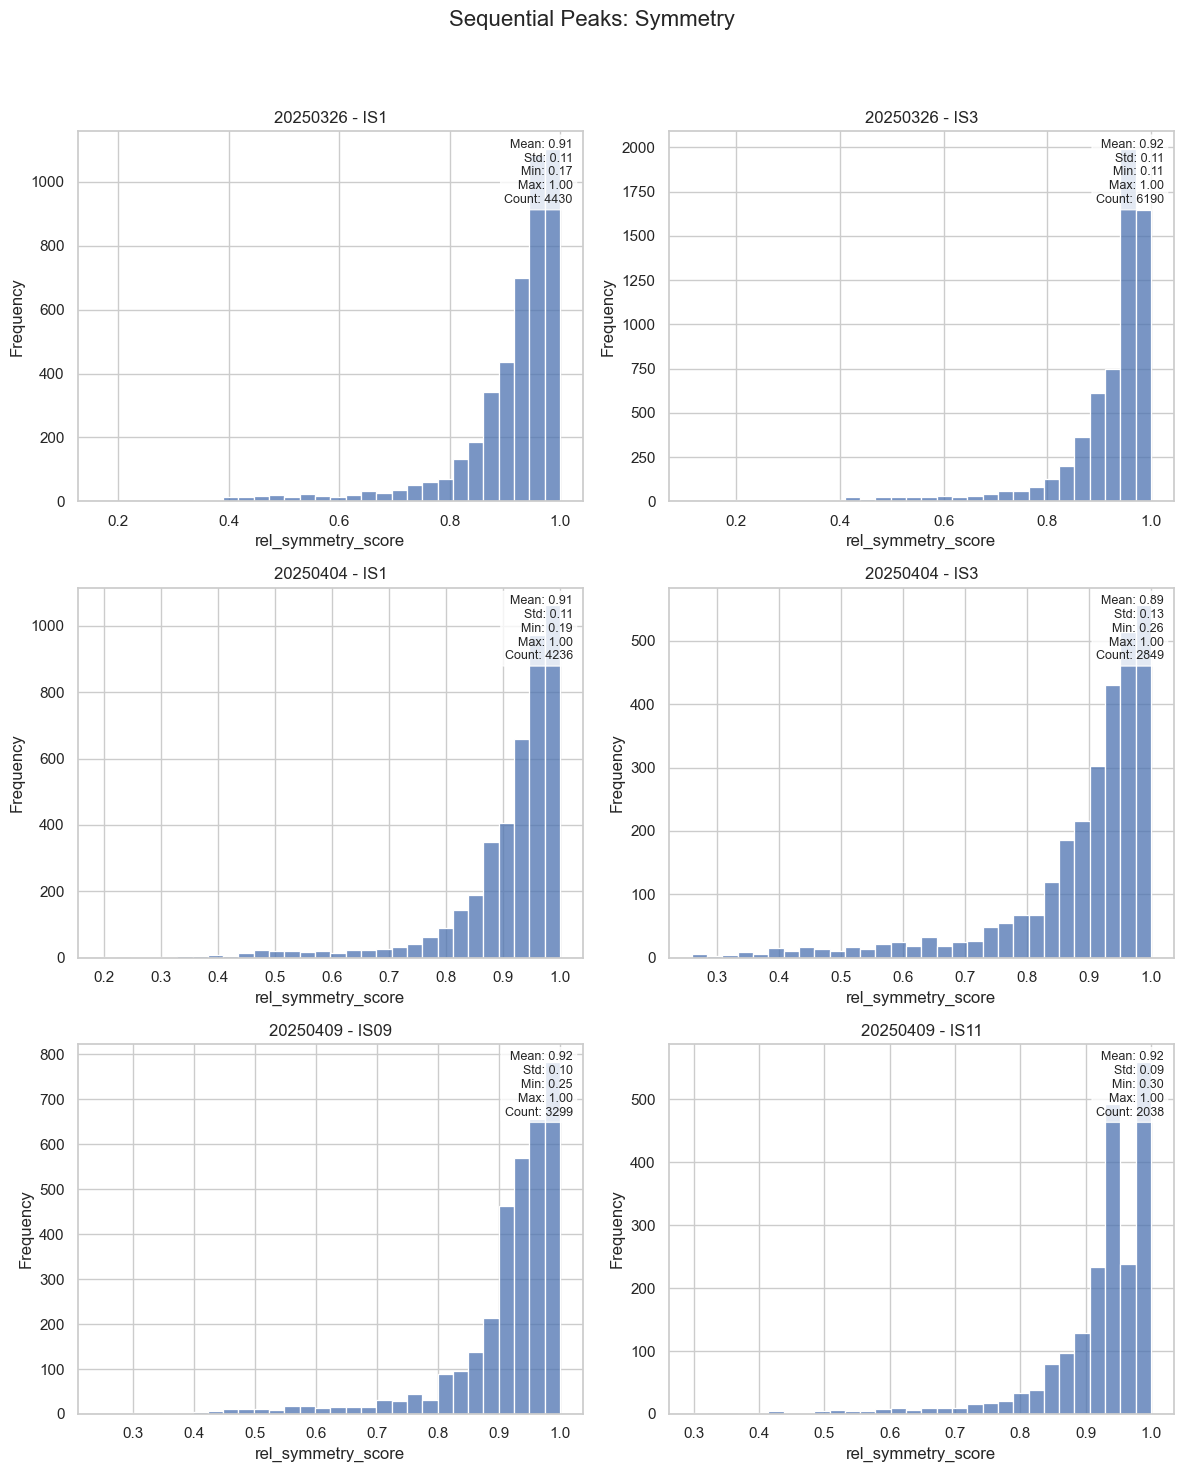


#🔍 Peak Type: Individual — 11261 peaks


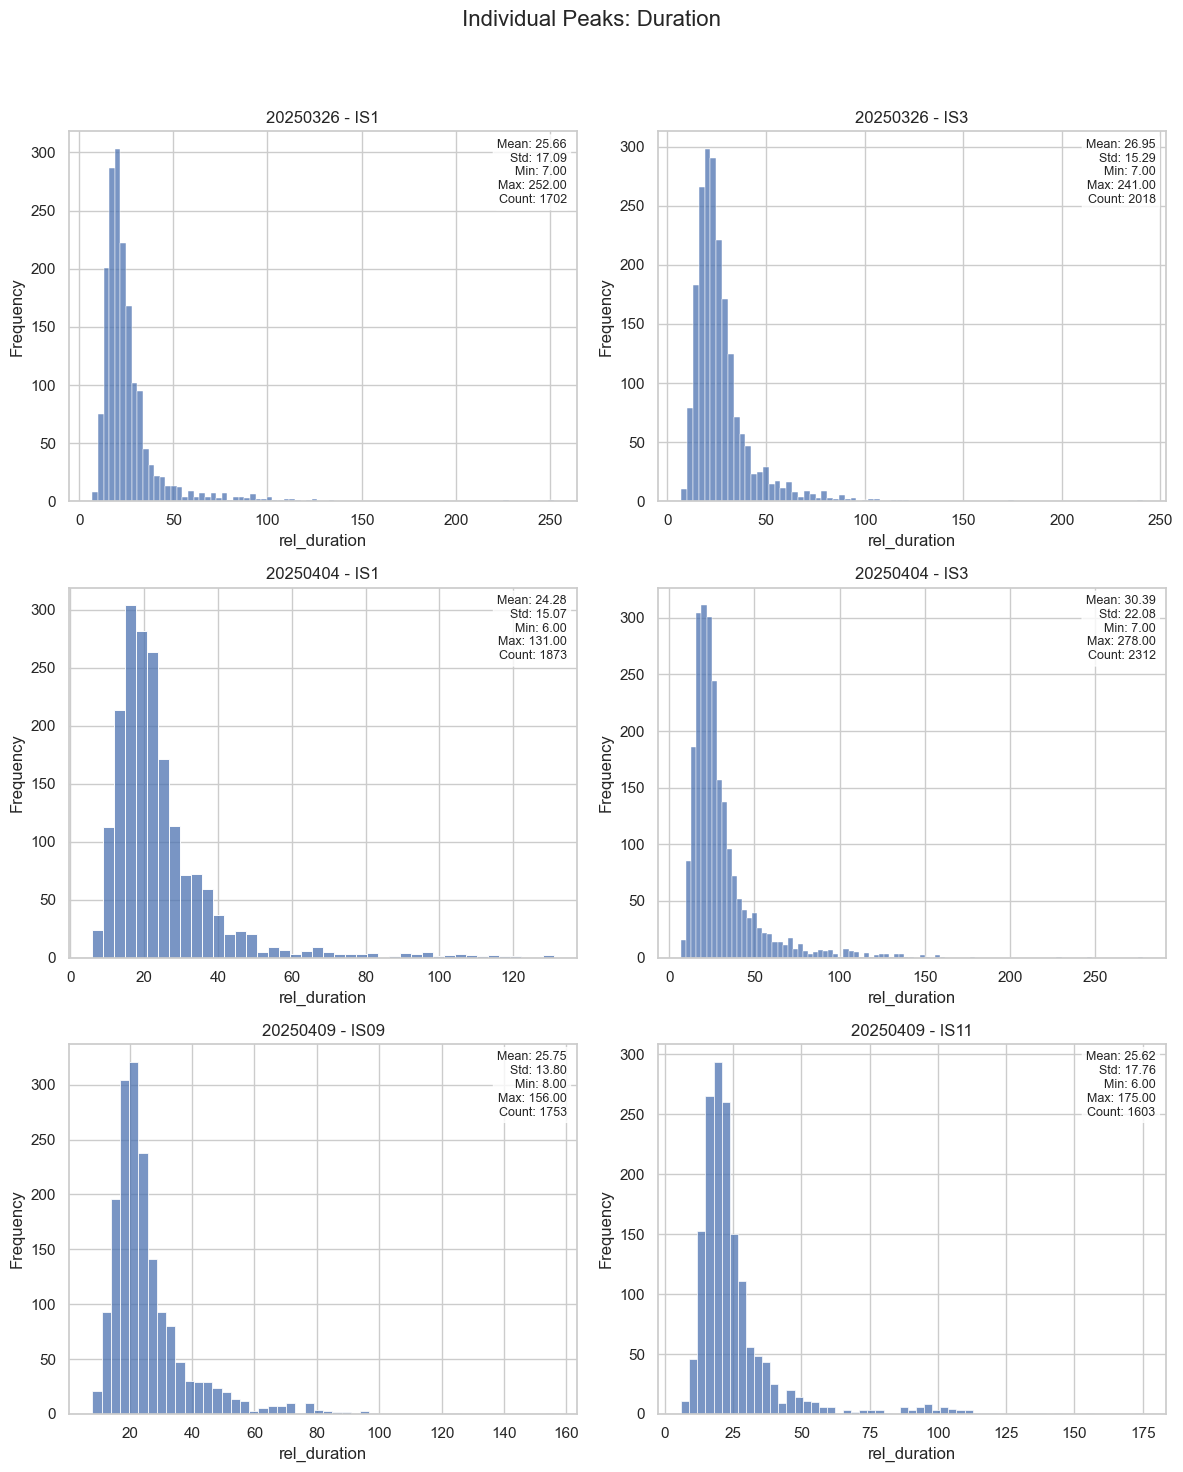

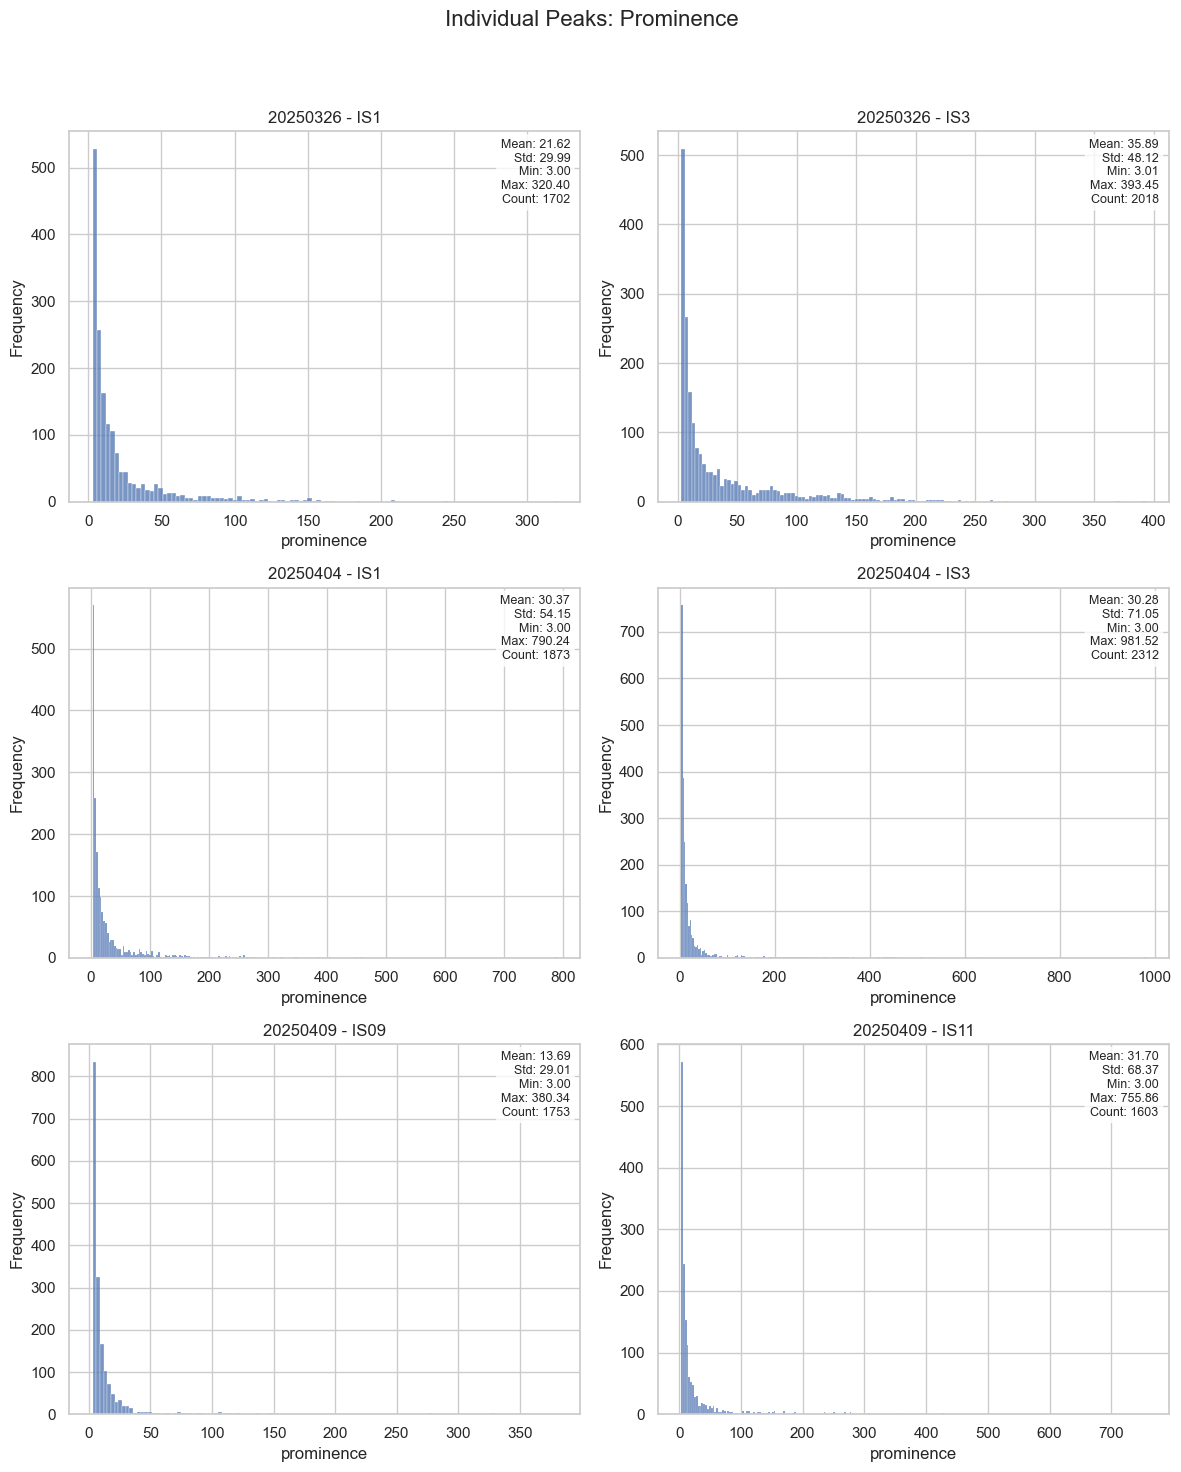

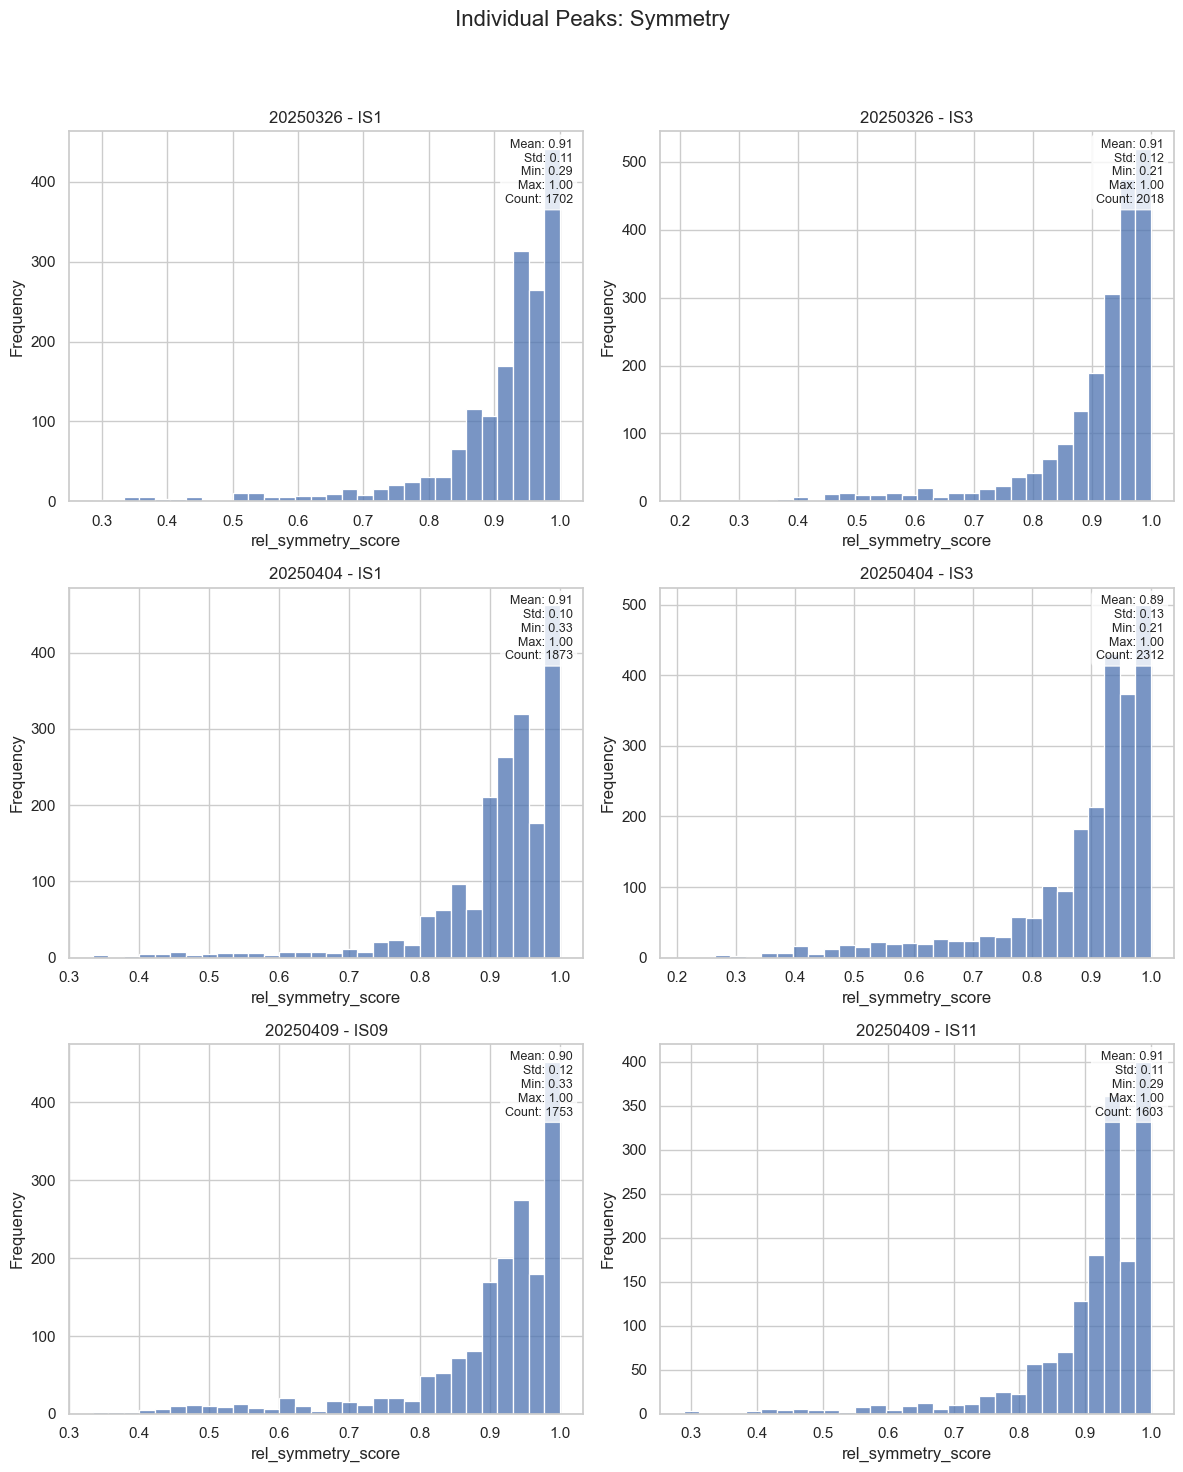

In [5]:

for event_type in ["global", "sequential", "individual"]:
    subset = peaks[peaks["in_event"] == event_type]
    print(f"\n#🔍 Peak Type: {event_type.title()} — {len(subset)} peaks")
    plot_metric_by_dataset(subset, "fhw_duration", f"{event_type.title()} Peaks: Duration", bin_width=3)
    plot_metric_by_dataset(subset, "prominence", f"{event_type.title()} Peaks: Prominence", bin_width=3)
    plot_metric_by_dataset(subset, "rel_symmetry_score", f"{event_type.title()} Peaks: Symmetry", bin_count=30)

## 🧬 Cell Metrics

We analyze:
- Number of peaks per cell (activity)
- Periodicity score (oscillatory behavior)
- Proportion of active vs inactive cells

*Interpretation:*

*Active cells:* 
*Nearly all cells (>99.9%) are active in every dataset. This indicates excellent signal integrity and robust experimental conditions.*
*Activity is highly homogeneous across datasets.*

*Number of peaks per cell:*
*High total peak count (>10,000 peaks per dataset), with a balanced and near-normal distribution.*
*This reflects widespread and stable activity across the population.*

*Periodicity:*
*Periodicity scores (~0.7 ± 0.1) remain consistent across both imaging runs.*
*This suggests that rhythmic calcium oscillations are preserved, even when global excitability drops.*


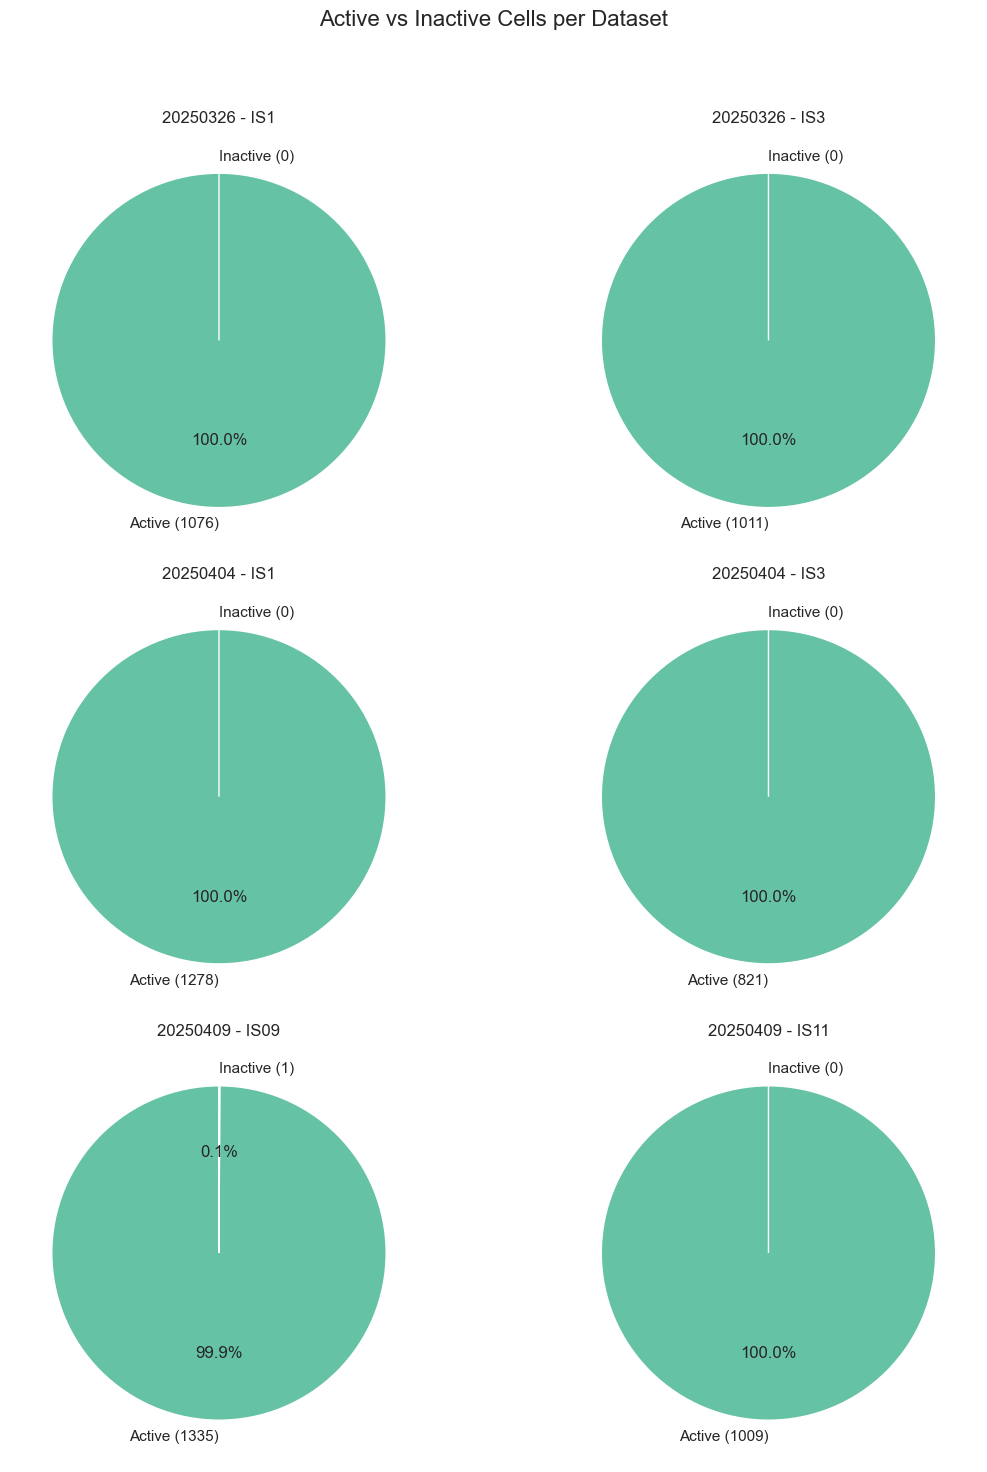

In [6]:
# Convert is_active to label for display purposes
cells["active_label"] = cells["is_active"].map({1: "Active", 0: "Inactive"})

plot_category_distribution_by_dataset(
    df=cells,
    column="active_label",
    category_order=["Active", "Inactive"],
    colors={"Active": "#66c2a5", "Inactive": "#d3d3d3"},
    title="Active vs Inactive Cells per Dataset"
)

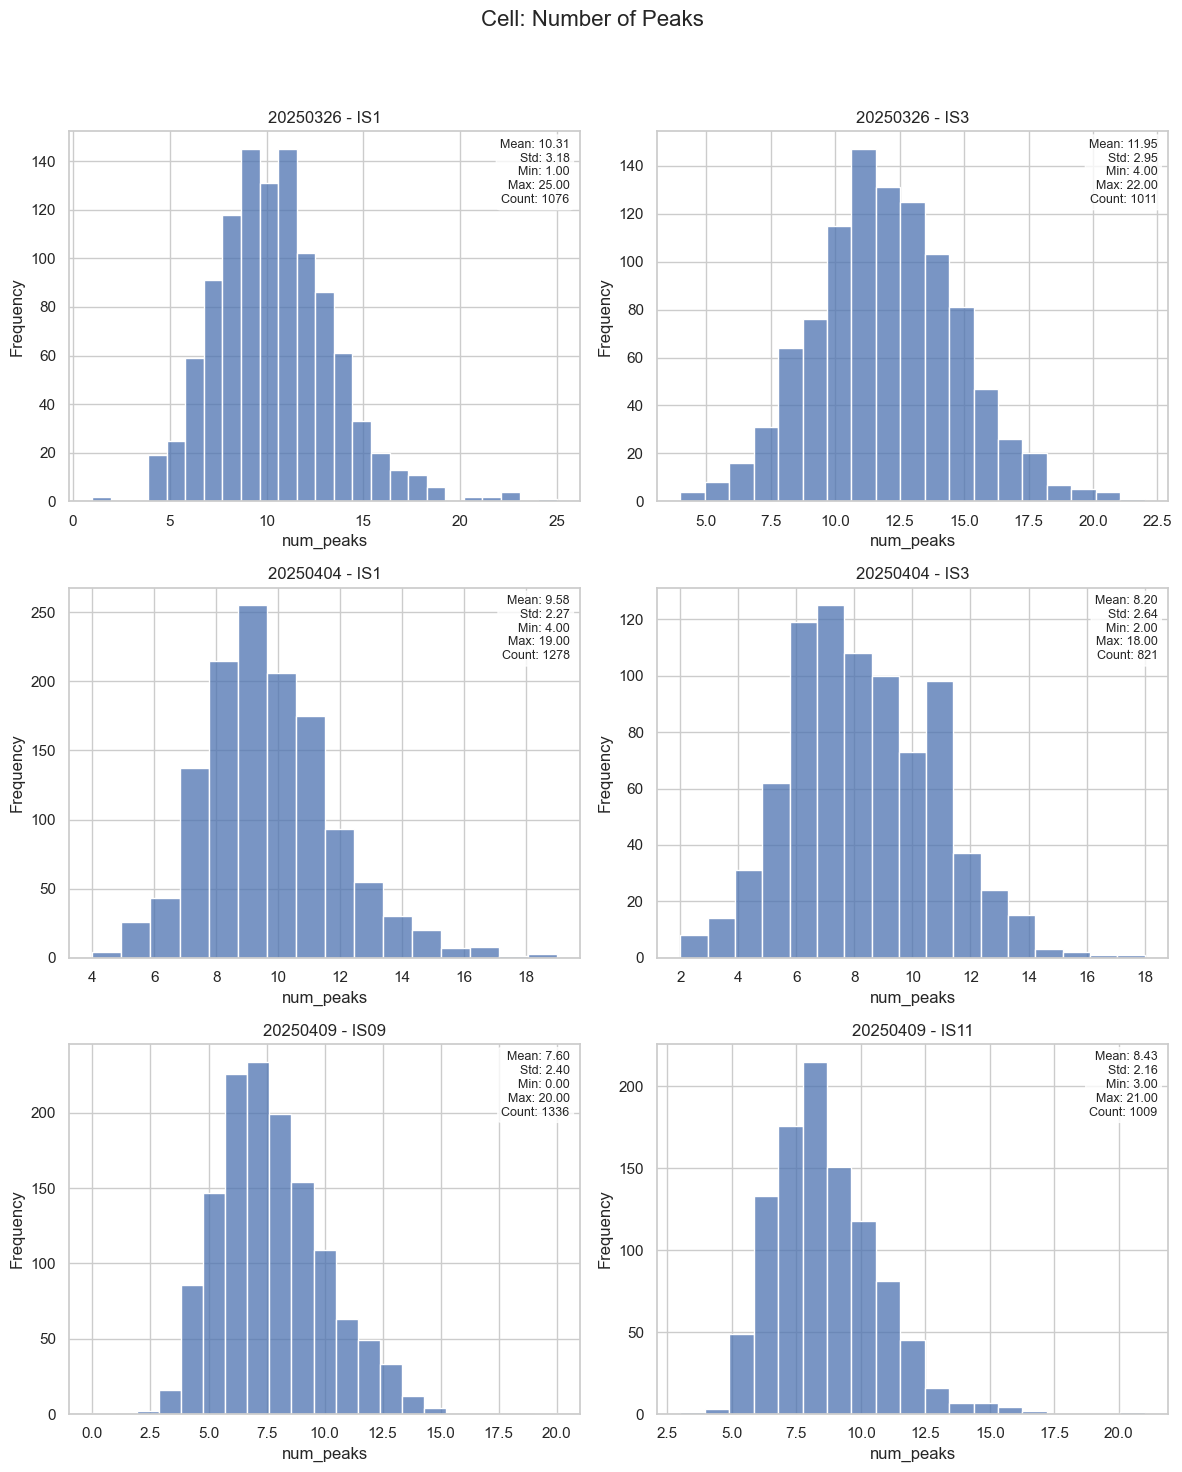

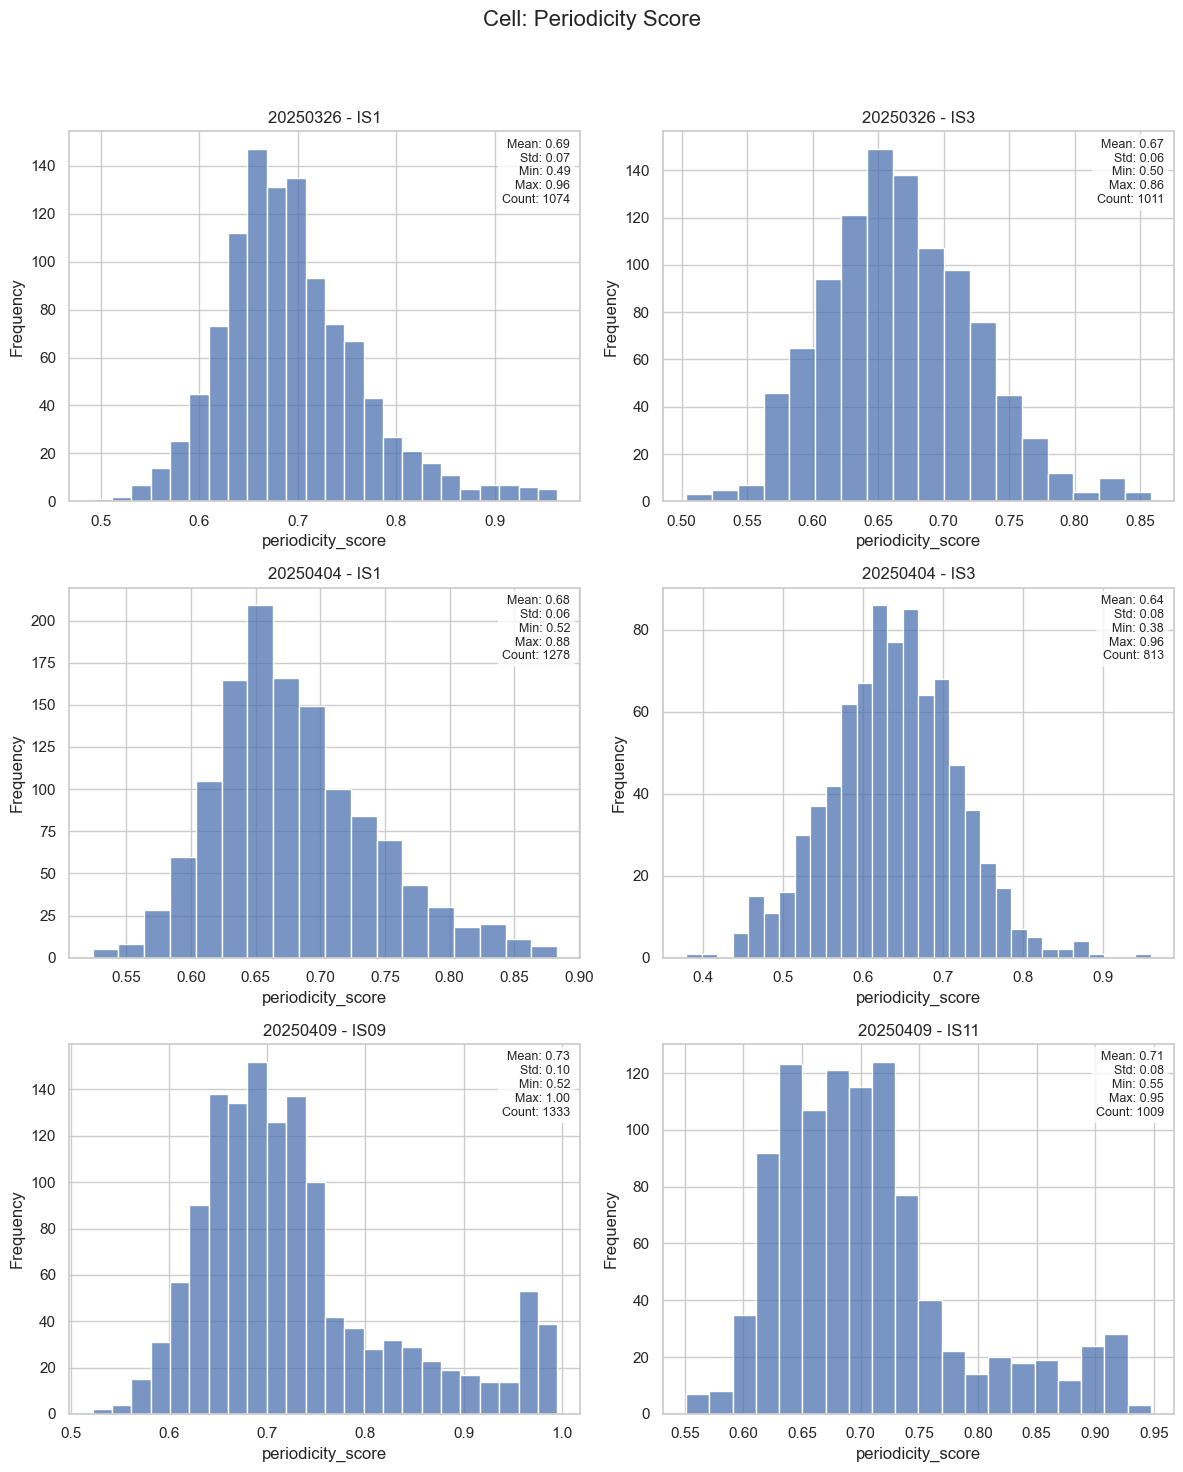

In [7]:
plot_metric_by_dataset(cells, "num_peaks", "Cell: Number of Peaks", bin_width=1)
plot_metric_by_dataset(cells, "periodicity_score", "Cell: Periodicity Score", bin_width=0.02)

## 🌊 Sequential Event Metrics

We focus on **spatiotemporal events**, extracting:
- Mean communication time and speed
- Geometric descriptors (elongation, radiality)
- Graph depth, number of involved cells


*Interpretation:*

- *Communication time: ~4.0 frames (STD ~2.5).*
- *Communication speed: ~6.2 units/frame.*
- *Cells involved: ~3.2 ± 2 cells per event.*

*These metrics are consistent across datasets and define the propagation baseline for healthy spontaneous events.*

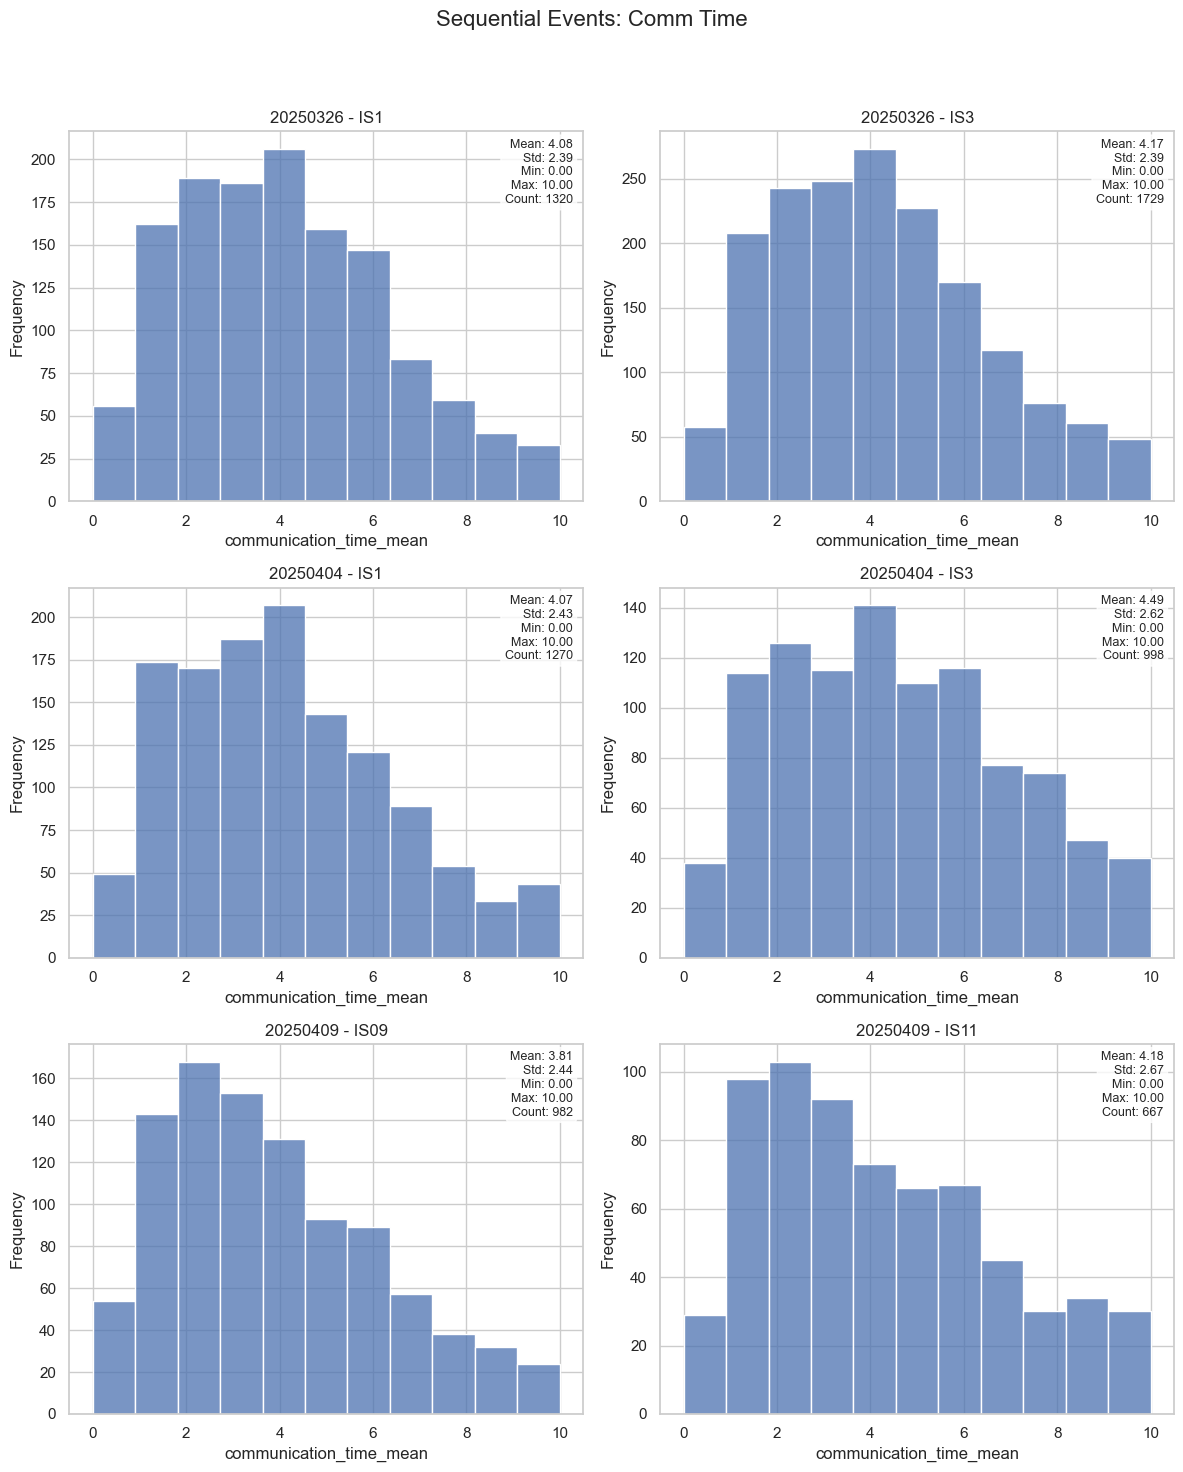

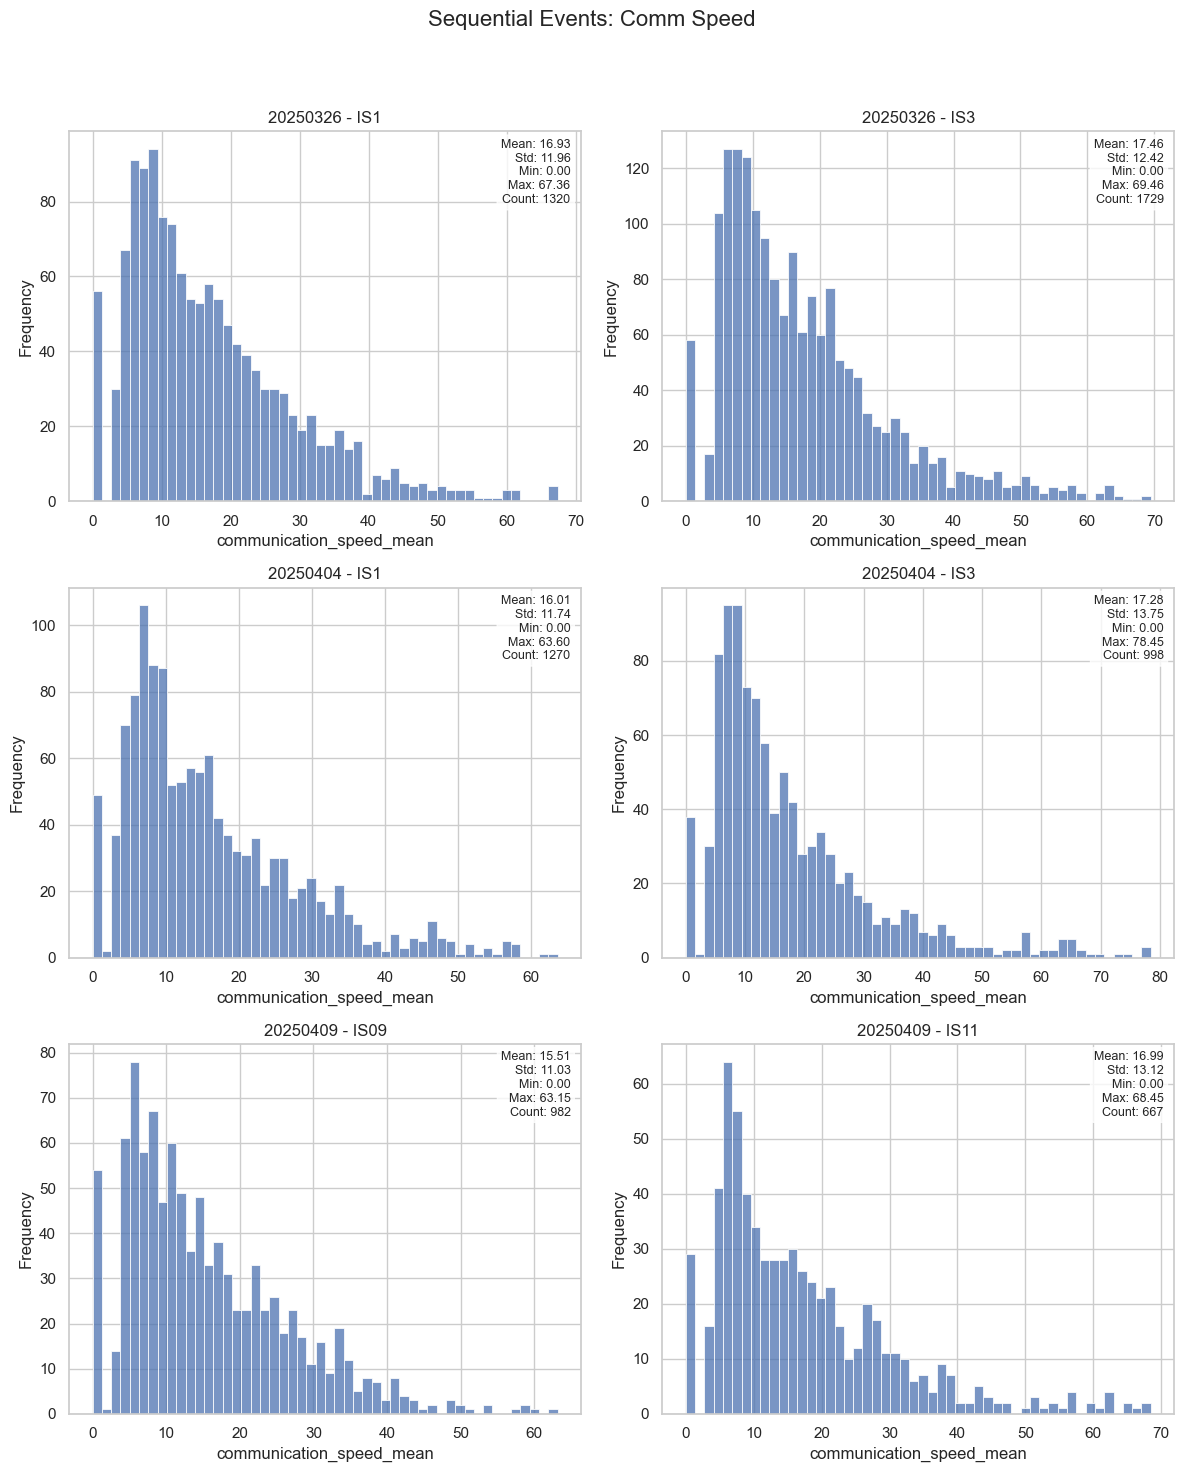

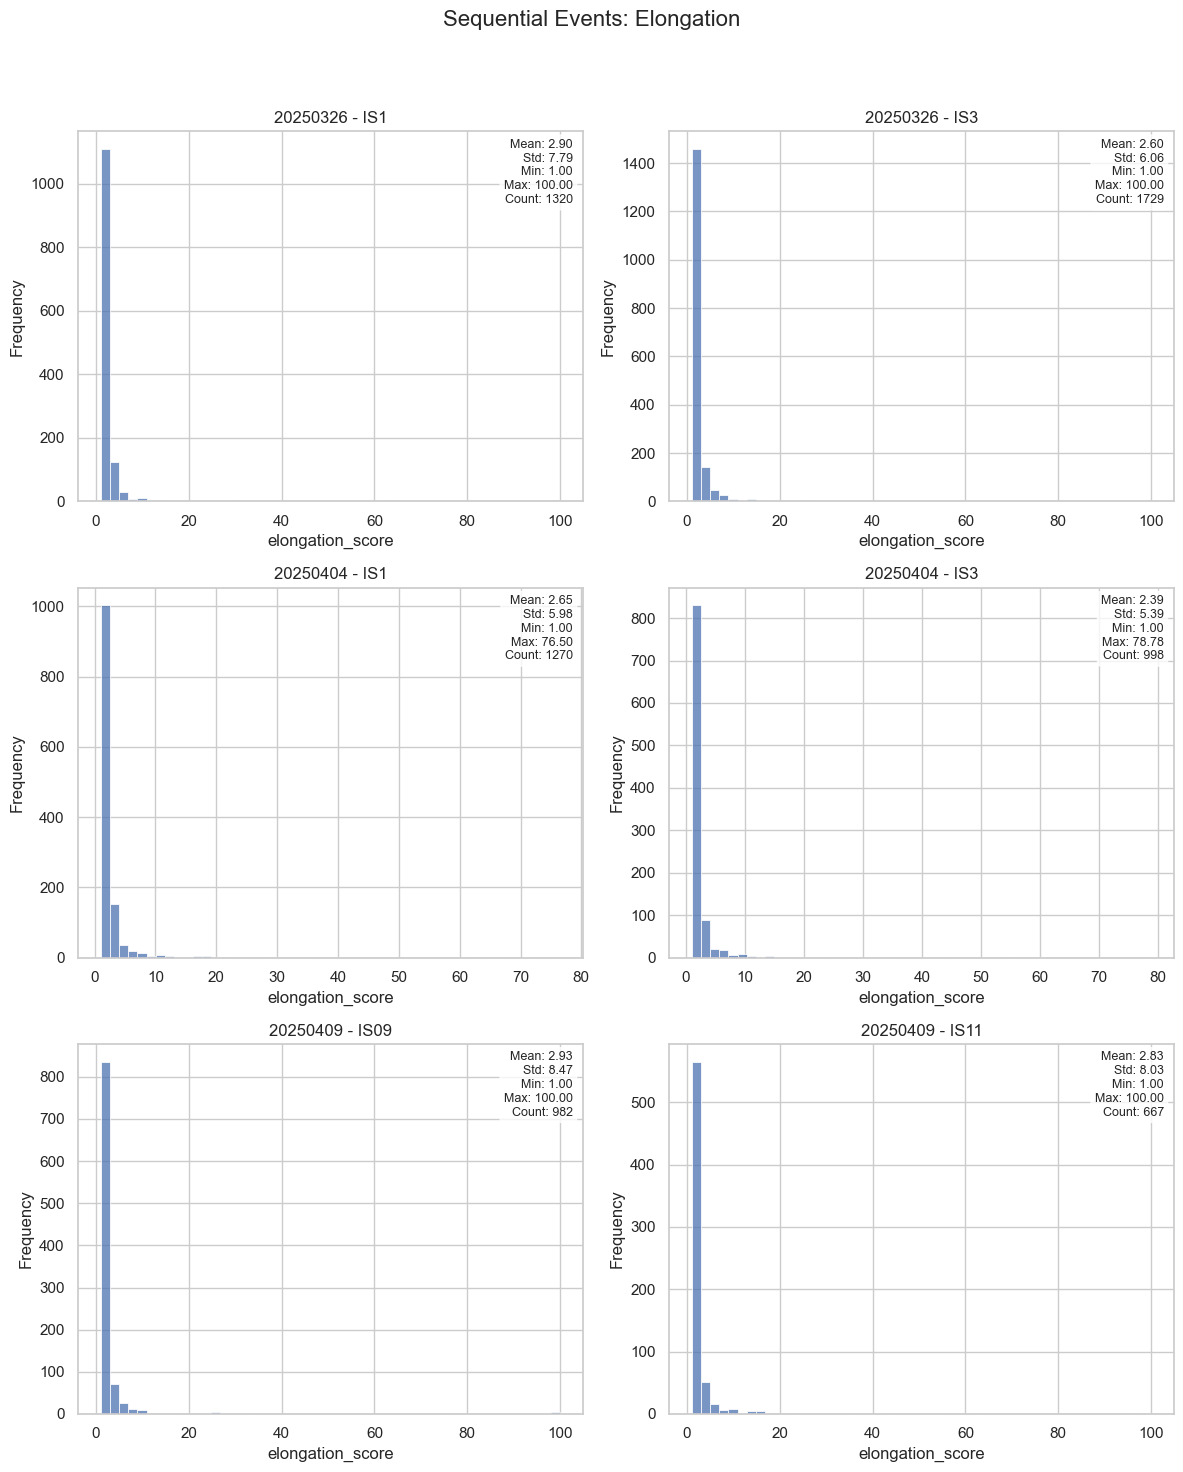

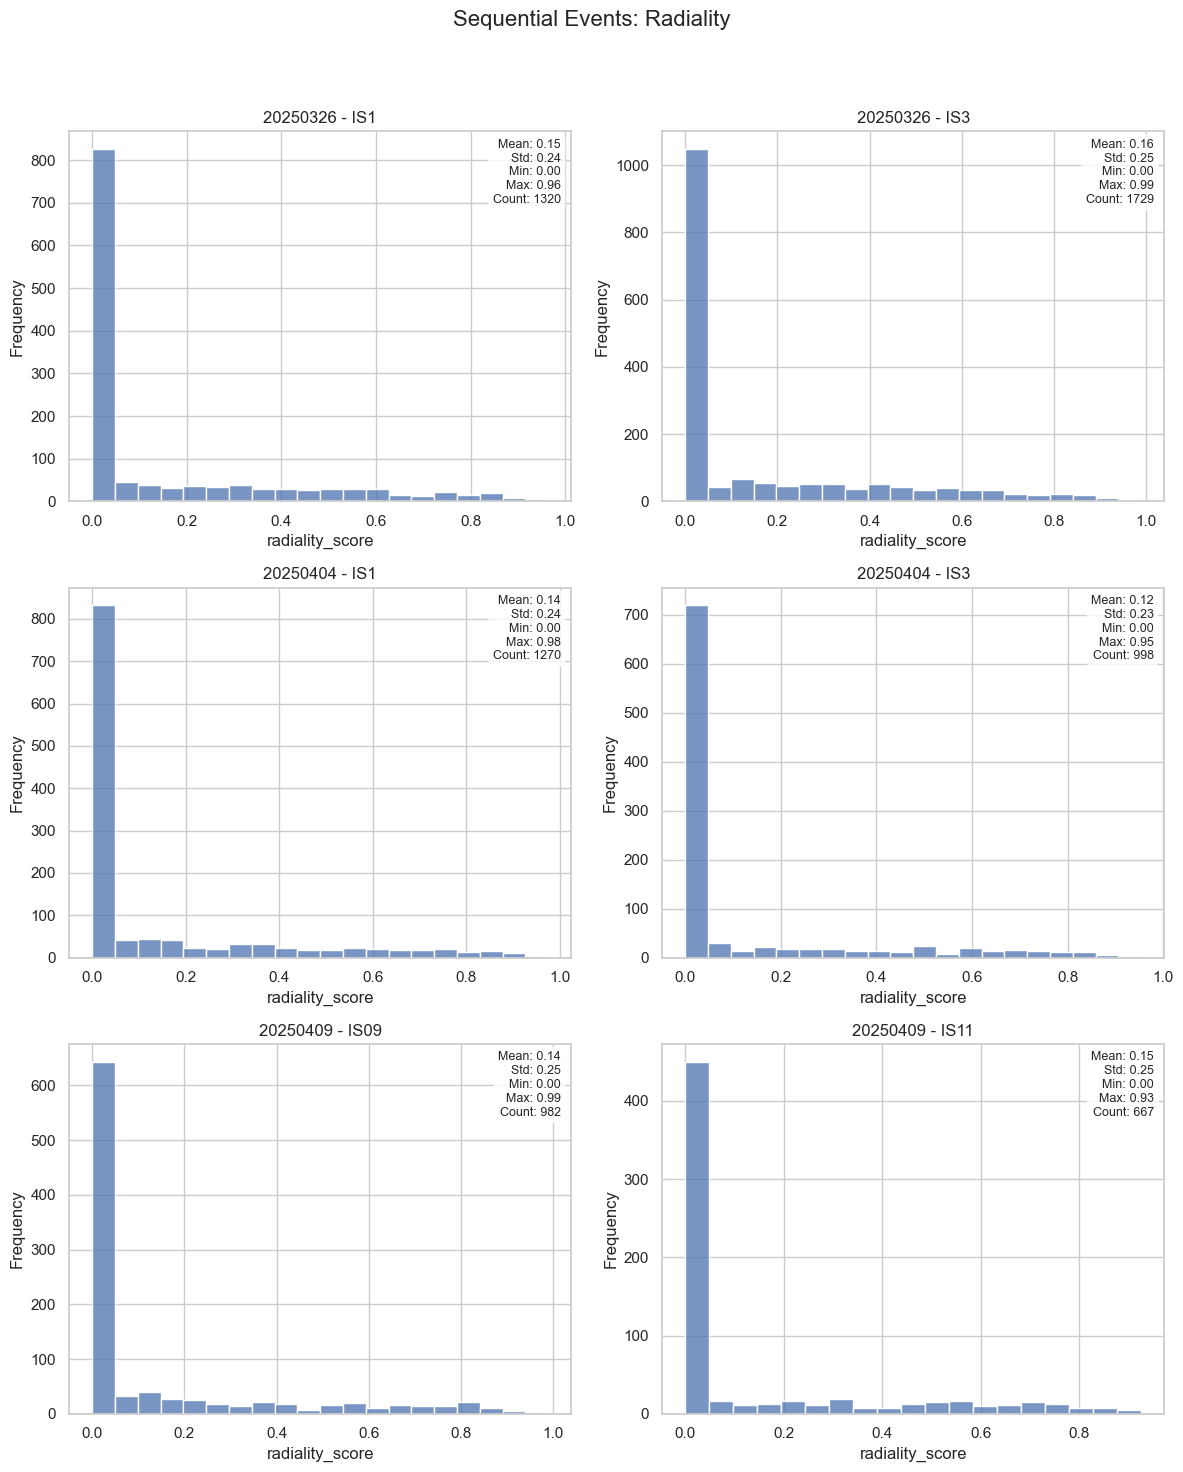

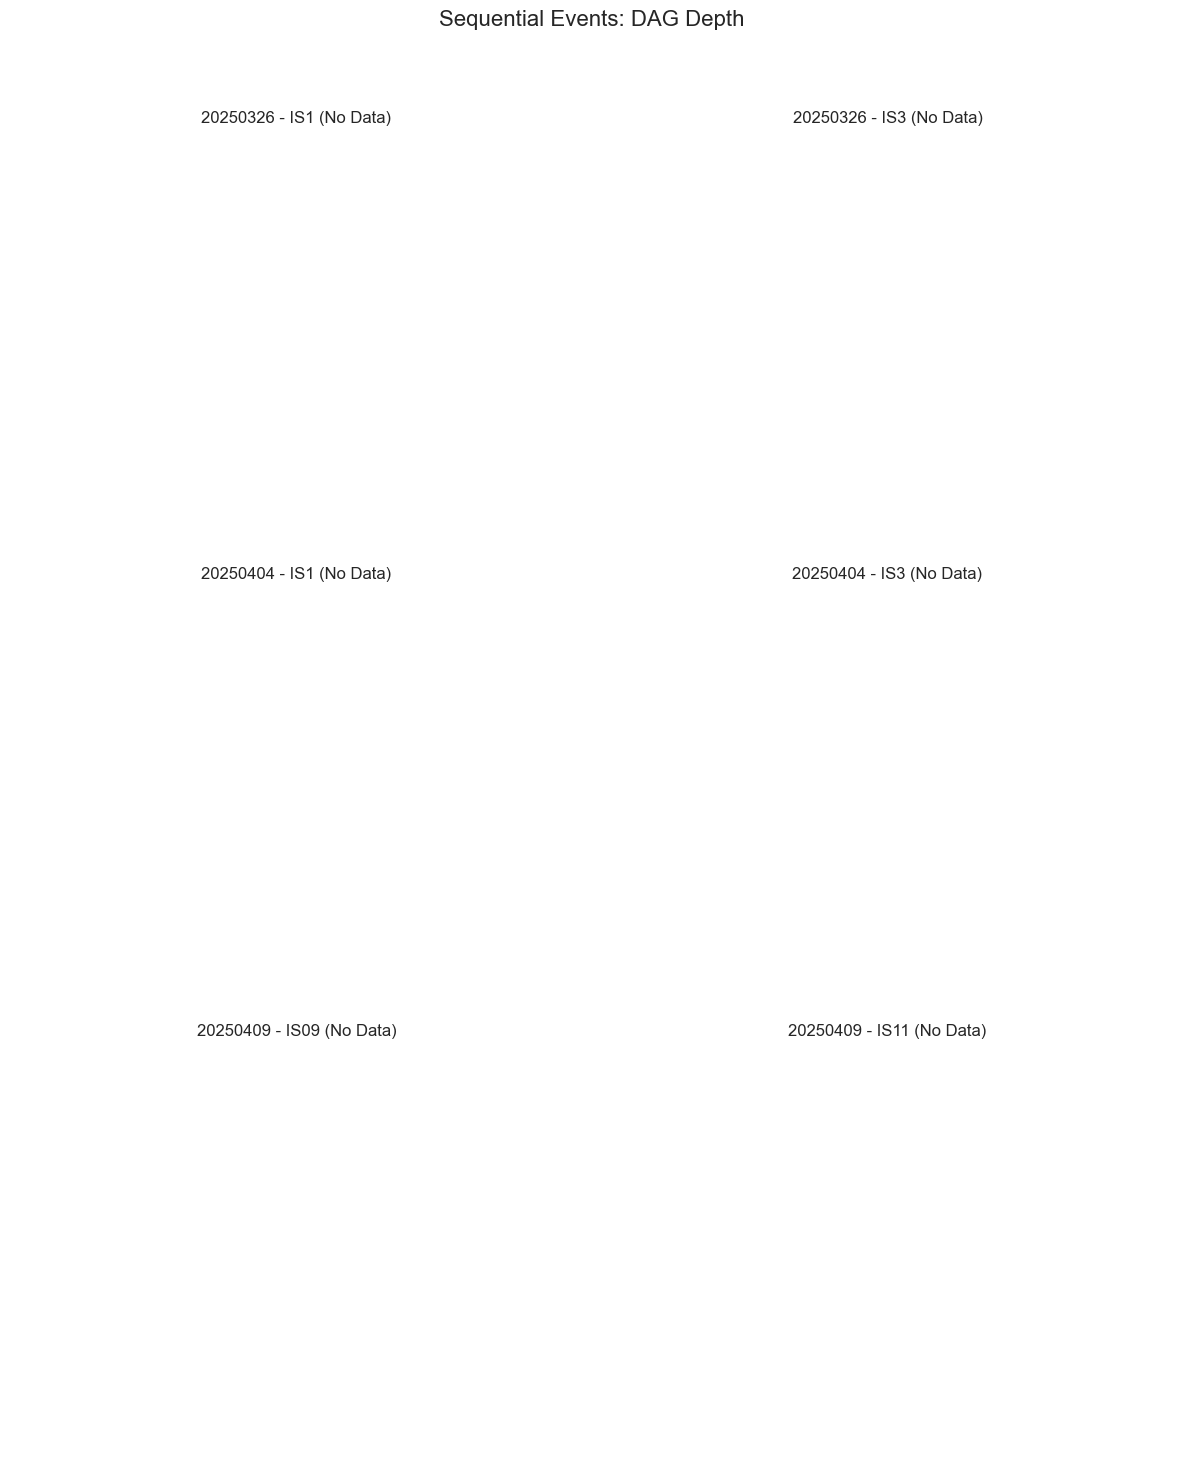

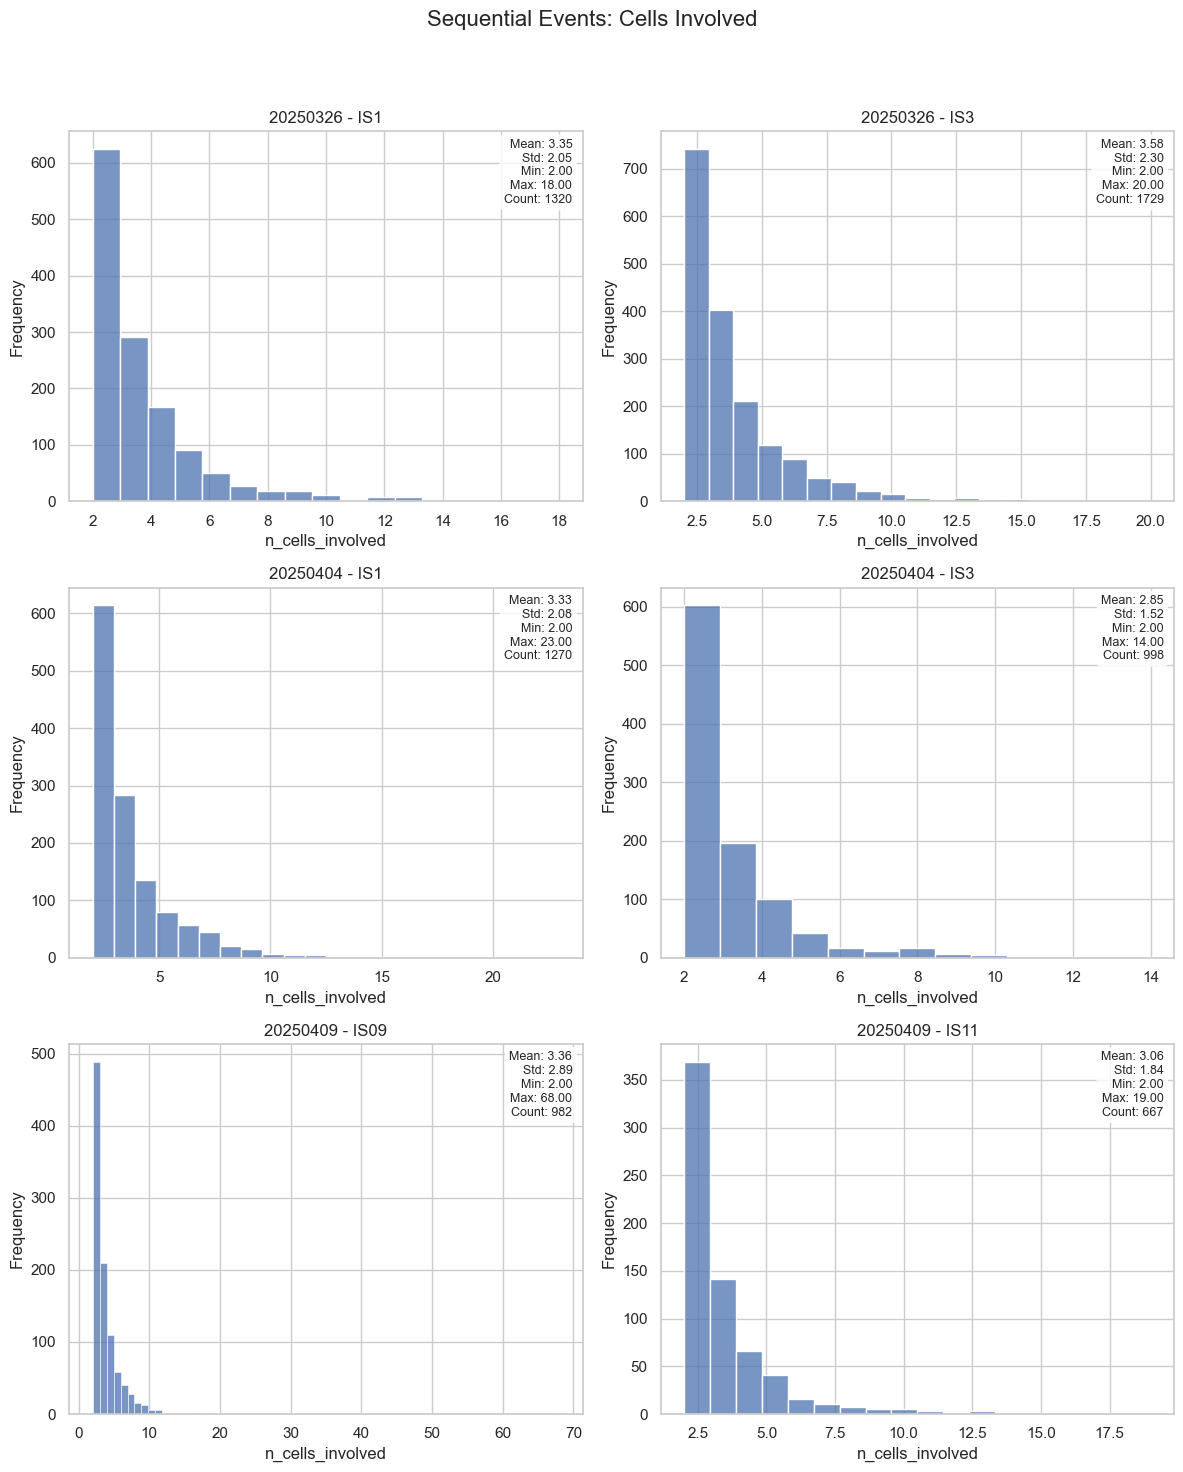

In [8]:
seq_events = events[events["event_type"] == "SequentialEvent"]
plot_metric_by_dataset(seq_events, "communication_time_mean", "Sequential Events: Comm Time", bin_width=1)
plot_metric_by_dataset(seq_events, "communication_speed_mean", "Sequential Events: Comm Speed", bin_count=50)
plot_metric_by_dataset(seq_events, "elongation_score", "Sequential Events: Elongation", bin_count=50)
plot_metric_by_dataset(seq_events, "radiality_score", "Sequential Events: Radiality", bin_width=0.05)
plot_metric_by_dataset(seq_events, "dag_depth", "Sequential Events: DAG Depth", bin_width=1)
plot_metric_by_dataset(seq_events, "n_cells_involved", "Sequential Events: Cells Involved", bin_width=1)

## 📌 Conclusion & Next Steps

### 🔍 Summary of Observations
- **Visual Patterns:** Briefly describe observed visual trends (raster plots, activity levels, etc.).
- **Statistical Results:** Mention key metrics or KS-test outcomes that stood out.

### 📉 Dataset Reproducibility
- Which datasets appear consistent or divergent?
- Are any replicates potentially faulty or biologically distinct?

### 🧪 Actionable Decisions
- [ ] Exclude dataset(s) due to technical issues
- [ ] Flag dataset(s) for further inspection
- [ ] Select representative samples for downstream analysis

### 📂 Planned Deep-Dive
- Which direction will the next notebook take? (e.g., spatial clustering, propagation analysis, signal decomposition)

---